In [1]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, RobertaModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    multilabel_confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
from datetime import datetime

In [2]:
# Add GPU count check at the top level
def get_available_gpus():
    """Get the number of available GPUs and their IDs"""
    if not torch.cuda.is_available():
        return 0, []
    
    n_gpus = torch.cuda.device_count()
    gpu_ids = list(range(n_gpus))
    return n_gpus, gpu_ids

In [3]:
class IssueDataset(Dataset):
    """
    Dataset for processing text data and multi-label classification.

    Args:
        texts (pd.Series): Series of input texts.
        labels (list or pd.Series): Corresponding labels (one-hot encoded for multi-label).
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for converting text to tokens.
        max_length (int): Maximum length of tokenized sequences (default is 512).
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.reset_index(drop=True)
        # Reset index for labels if it's a pandas Series.
        if isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        # For multi-label classification, ensure we're passing the full label array
        # and not just a single value
        label = self.labels[idx]
        
        # Make sure we're getting a proper multi-dimensional label array
        # and not flattening it incorrectly
        if isinstance(label, (list, np.ndarray)):
            # Convert directly to tensor without modifying shape
            label = torch.tensor(label, dtype=torch.float)
        else:
            # If it's not already an array-like structure, this is likely a mistake
            # as we expect multi-label one-hot encoded data
            raise ValueError(f"Expected multi-dimensional label array but got {type(label)}")
        
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'labels': label
        }

In [4]:
class CodeBERTClassifier(nn.Module):
    """
    A classifier model based on CodeBERT for multi-label classification.
    
    This model uses a pre-trained CodeBERT model as the encoder and adds a 
    classification head on top with sigmoid activation for multi-label output.
    
    Args:
        num_labels (int): Number of classes in the multi-label classification task.
    """
    def __init__(self, num_labels):
        super().__init__()
        self.codebert = RobertaModel.from_pretrained('microsoft/codebert-base')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)
        # Freeze all parameters in CodeBERT
        for param in self.codebert.parameters():
            param.requires_grad = False
        # Unfreeze pooler parameters for fine-tuning
        for param in self.codebert.pooler.parameters():
            param.requires_grad = True
        # Unfreeze parameters of the last 3 encoder layers
        for layer in self.codebert.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        # Return raw logits for BCEWithLogitsLoss (sigmoid will be applied in the loss function)
        return self.classifier(pooled_output)


In [5]:
class EarlyStopping:
    """
    Early stopping to stop training when the validation loss does not improve sufficiently.
    
    For multi-label classification, we consider a loss improvement when 
    the validation loss decreases by at least min_delta.
    
    Args:
        patience (int): Number of epochs to wait for an improvement before stopping.
        min_delta (float): Minimum decrease in the monitored loss to qualify as an improvement.
    """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def reset(self):
        """Reset the early stopping state."""
        self.counter = 0
        self.best_loss = None
        self.early_stop = False


In [6]:
def train_epoch(model, loader, criterion, optimizer, device, threshold=0.5, early_stopping=None):
    """
    Train the model for one epoch, computing loss and metrics for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Training DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        optimizer: Optimization algorithm.
        device: Device to perform training (CPU or GPU).
        threshold (float): Threshold for binary predictions (default is 0.5).
        early_stopping (EarlyStopping, optional): Instance to monitor improvement in loss.

    Returns:
        tuple: Average loss, Hamming accuracy, and a flag indicating if early stopping was triggered.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # Apply sigmoid and threshold for predictions
        predictions = torch.sigmoid(outputs) >= threshold
        all_preds.append(predictions.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    
    # Calculate metrics for multi-label classification
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Use subset accuracy (exact match) for a strict measure
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    avg_loss = total_loss / len(loader)
    
    if early_stopping:
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            return avg_loss, exact_match, True
            
    return avg_loss, exact_match, False
  

In [7]:
def validate(model, loader, criterion, device, threshold=0.5):
    """
    Evaluate the model on provided validation data for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Validation DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        device: Device to perform evaluation.
        threshold (float): Threshold for binary predictions (default is 0.5).

    Returns:
        tuple: Average loss, various accuracy metrics, precision, recall, and F1 score.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Apply sigmoid and threshold for predictions
            predictions = (torch.sigmoid(outputs) >= threshold).float()
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate different multi-label metrics
    
    # 1. Exact Match / Subset Accuracy (all labels must be correct)
    subset_accuracy = (all_preds == all_labels).all(axis=1).mean()
    
    # 2. Hamming Accuracy (fraction of correct labels)
    hamming_accuracy = (all_preds == all_labels).mean()
    
    # 3. Jaccard Similarity (intersection over union)
    def jaccard_score(y_true, y_pred):
        intersection = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        # Create a float array for output to avoid type casting error
        result = np.zeros_like(intersection, dtype=float)
        # Avoid division by zero
        np.divide(intersection, union, out=result, where=union!=0)
        return np.mean(result)
    
    jaccard_sim = jaccard_score(all_labels.astype(bool), all_preds.astype(bool))
    
    # Sample-based metrics - Each sample contributes equally regardless of number of labels
    precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    
    return (total_loss / len(loader), 
            {"exact_match": subset_accuracy, 
             "hamming": hamming_accuracy, 
             "jaccard": jaccard_sim}, 
            precision, recall, f1)


In [8]:
def plot_multilabel_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrices for each label in a multi-label classification problem.
    
    Args:
        y_true (numpy.ndarray): True binary labels.
        y_pred (numpy.ndarray): Predicted binary labels.
        class_names (list): Names of the classes/labels.
    """
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)
    
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 3) // 4, ncols=min(4, num_classes), 
                             figsize=(20, 5 * ((num_classes + 3) // 4)))
    if num_classes == 1:
        axes = np.array([axes])  # Make it indexable for single class
    axes = axes.flatten()
    
    for i, matrix in enumerate(confusion_matrices):
        if i < num_classes:  # Ensure we don't exceed the number of classes
            ax = axes[i]
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Label: {class_names[i]}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    return fig

In [9]:
def prepare_data(df, text_column='all_text', min_label_freq=0, max_label_len=100, min_label_comb_freq=0):
    """
    Filter out infrequent labels and samples with too many labels.
    
    Args:
        df (pd.DataFrame): DataFrame with text column and 'labels'
        text_column (str): Name of the column containing the text data to use
        min_label_freq (int): Minimum frequency for a label to be considered frequent.
        max_label_len (int): Maximum number of labels per sample.
        min_label_comb_freq (int): Minimum frequency for a label combination to be kept.

    Returns:
        tuple: Filtered texts and labels.
    """
    # Only keep text column and 'labels' columns
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        # Filter out rows with 'nan' text
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
    else:
        raise ValueError(f"Text column '{text_column}' not found in the DataFrame. Available columns: {df.columns.tolist()}")
    
    # Drop rows with missing labels
    df = df.dropna()
    
    # Extract issue texts and labels
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists

    # Get labels count distribution
    label_distribution = Counter([label for labels in labels for label in labels])

    # Labels to keep based on frequency
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    print(f"Number of labels with at least {min_label_freq} occurrences: {len(frequent_labels)}")
    print(f"Removed {len(label_distribution) - len(frequent_labels)} infrequent labels")

    # Filter out infrequent labels
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    print(f"Number of samples after filtering: {len(filtered_labels)}")

    # Get label combinations distribution
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    frequent_combinations = {labels: count for labels, count in label_combinations.items() if count >= min_label_comb_freq}
    print(f"Number of label combinations with at least {min_label_comb_freq} occurrences: {len(frequent_combinations)}")
    print(f"Removed {len(label_combinations) - len(frequent_combinations)} infrequent label combinations")
    
    # Create mask for samples with frequent label combinations (if min_label_comb_freq > 0)
    if min_label_comb_freq > 0:
        comb_mask = filtered_labels.apply(lambda x: tuple(sorted(x)) in frequent_combinations)
        print(f"Number of samples with frequent label combinations: {comb_mask.sum()}")
    else:
        comb_mask = pd.Series([True] * len(filtered_labels))
    
    # Filter by label length
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    
    # Combine both masks
    final_mask = comb_mask & length_mask
    
    # Now get the final filtered texts and labels
    texts = texts[final_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[final_mask].reset_index(drop=True)
    
    print(f"Final number of samples after all filtering: {len(filtered_labels)}")
    
    return texts, filtered_labels

In [17]:
def main(args):
    """
    Main function to run the multi-label classification pipeline with CodeBERT.
    This function loads data, preprocesses it, trains the model, and evaluates performance.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check for GPU availability
    n_gpus, gpu_ids = get_available_gpus()
    if n_gpus >= 2:
        print(f"Using {n_gpus} GPUs: {gpu_ids}")
        device = torch.device("cuda")
        use_multi_gpu = True
    elif n_gpus == 1:
        print("Using 1 GPU")
        device = torch.device("cuda")
        use_multi_gpu = False
    else:
        print("No GPUs available, using CPU")
        device = torch.device("cpu")
        use_multi_gpu = False
    
    # Make results directory if it doesn't exist
    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)
    
    # Create a timestamped directory for this run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}_{args.text_column}")
    os.makedirs(run_dir, exist_ok=True)
    
    # Load data
    print(f"Loading data from {args.data_path}...")
    df = pd.read_json(args.data_path)
    
    # Check if the text column exists
    if args.text_column not in df.columns:
        available_columns = [col for col in df.columns if col.startswith('all_text')]
        print(f"Text column '{args.text_column}' not found. Available text columns: {available_columns}")
        if len(available_columns) == 0:
            raise ValueError("No text columns found in the data")
        args.text_column = available_columns[0]
        print(f"Using '{args.text_column}' instead")
    
    # Use prepare_data function to filter and prepare data
    texts, filtered_labels = prepare_data(
        df, 
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len, 
        min_label_comb_freq=args.min_label_comb_freq
    )
    
    # Count the number of labels distribution
    label_distribution = Counter([label for labels in filtered_labels for label in labels])
    print('\n Label Distribution : ')
    for i, (label, count) in enumerate(sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. {label}: {count}')
    
    # Count the label length distribution
    label_length_distribution = Counter([len(labels) for labels in filtered_labels])
    print('\n Label count per row distribution:')
    for label in sorted(label_length_distribution.keys()):
        print(f'Label: {label}, count: {label_length_distribution[label]}')

    # Count the distribution of label combinations
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    print('\n Label combinations distribution:')
    for i, (labels, count) in enumerate(sorted(label_combinations.items(), key=lambda x: x[1], reverse=True)):
        if i < 20:  # Show only the top 20 combinations
            print(f'{i}. Label combination: {labels}, count: {count}')
    
    # Encode multi-labels using MultiLabelBinarizer
    print("Encoding labels...")
    mlb = MultiLabelBinarizer()
    labels_encoded = mlb.fit_transform(filtered_labels)
    
    # Save label encoder for future use
    with open(os.path.join(run_dir, 'label_encoder.json'), 'w') as f:
        json.dump({
            'classes': mlb.classes_.tolist()
        }, f)
    
    # Calculate label distribution
    label_counts = labels_encoded.sum(axis=0)
    
    # Log class imbalance metrics
    label_density = label_counts.sum() / (labels_encoded.shape[0] * labels_encoded.shape[1])
    print(f"Label density: {label_density:.4f}")
    print(f"Average labels per sample: {label_counts.sum() / labels_encoded.shape[0]:.2f}")
    
    # Split data into training and validation sets (80% training, 20% validation)
    split_idx = int(len(texts) * 0.8)
    train_texts, val_texts = texts[:split_idx], texts[split_idx:]
    train_labels, val_labels = labels_encoded[:split_idx], labels_encoded[split_idx:]
    
    print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}")
    
    # Initialize tokenizer
    print("Loading tokenizer...")
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    
    # Implement class weights for loss function to handle imbalance
    pos_weights = None
    if args.use_class_weights and label_counts.min() < label_counts.max() / 5:  # If there's significant imbalance
        print("Computing class weights for imbalanced labels...")
        pos_weights = torch.FloatTensor(
            (labels_encoded.shape[0] - label_counts) / label_counts
        ).clamp(0.5, 10).to(device)  # Limit range to prevent extreme weights
    
    # Create datasets and dataloaders
    batch_size = args.batch_size
    train_dataset = IssueDataset(train_texts, train_labels, tokenizer)
    val_dataset = IssueDataset(val_texts, val_labels, tokenizer)
    
    # Increase batch size for DataParallel if multiple GPUs
    if use_multi_gpu:
        batch_size = batch_size * n_gpus
        print(f"Using larger batch size of {batch_size} for {n_gpus} GPUs")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model, loss function, and optimizer
    print("Initializing model...")
    model = CodeBERTClassifier(num_labels=len(mlb.classes_)).to(device)
    
    # Use DataParallel for multiple GPUs
    if use_multi_gpu:
        model = nn.DataParallel(model)
        print("Model wrapped in DataParallel")
    
    # Use weighted loss if we have weights
    if pos_weights is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        print("Using weighted BCE loss")
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=args.patience, min_delta=0.01)
    
    # Training loop
    num_epochs = args.epochs
    print(f"Starting training for {num_epochs} epochs...")
    
    train_losses = []
    val_losses = []
    best_f1 = 0.0
    best_model_saved = False  # Flag to track if we've saved at least one model
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch
        train_loss, train_acc, stop_early = train_epoch(
            model, train_loader, criterion, optimizer, device, early_stopping=early_stopping
        )
        
        # Validate
        val_loss, accuracy_metrics, val_precision, val_recall, val_f1 = validate(
            model, val_loader, criterion, device
        )
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy (Exact Match): {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy (Exact Match): {accuracy_metrics['exact_match']:.4f}")
        print(f"Val Accuracy (Hamming): {accuracy_metrics['hamming']:.4f}")
        print(f"Val Accuracy (Jaccard): {accuracy_metrics['jaccard']:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        
        # Save best model based on F1 score
        model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            
            # Save the model state_dict (handle DataParallel wrapper if needed)
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
                
            print(f"Saved new best model to {model_path}")
            best_model_saved = True
        
        # Always save a model for the first epoch if no model has been saved yet
        # This ensures we have at least one model if early stopping occurs
        if epoch == 0 and not best_model_saved:
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
            print(f"Saved initial model to {model_path} as baseline")
            best_model_saved = True
            
        # Check for early stopping
        if stop_early:
            print("Early stopping triggered. Terminating training.")
            break
    
    # Save training history
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    with open(os.path.join(run_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f)
    
    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    best_model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
    
    # Handle loading for DataParallel model
    if use_multi_gpu:
        model.module.load_state_dict(torch.load(best_model_path))
    else:
        model.load_state_dict(torch.load(best_model_path))
    
    # Evaluate the model with default threshold
    print("\nFinal evaluation with default threshold (0.5):")
    final_loss, final_acc_metrics, final_precision, final_recall, final_f1 = validate(
        model, val_loader, criterion, device
    )
    
    print(f"Exact Match Accuracy: {final_acc_metrics['exact_match']:.4f}")
    print(f"Hamming Accuracy: {final_acc_metrics['hamming']:.4f}")
    print(f"Jaccard Similarity: {final_acc_metrics['jaccard']:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    
    # Save results
    results = {
        'text_column': args.text_column,
        'metrics': {
            'exact_match': float(final_acc_metrics['exact_match']),
            'hamming': float(final_acc_metrics['hamming']),
            'jaccard': float(final_acc_metrics['jaccard']),
            'precision': float(final_precision),
            'recall': float(final_recall), 
            'f1': float(final_f1),
        }
    }
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Collect predictions with default threshold for confusion matrices
    model.eval()
    all_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_val_labels.append(batch['labels'].numpy())
    
    all_preds = np.vstack(all_preds)
    all_val_labels = np.vstack(all_val_labels)
    
    # Plot and save confusion matrices (up to 20 labels to avoid too many plots)
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        all_val_labels[:, :num_labels_to_plot], 
        all_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot]
    )
    plt.savefig(os.path.join(run_dir, 'confusion_matrices.png'))
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training History - {args.text_column}')
    plt.legend()
    plt.savefig(os.path.join(run_dir, 'training_history.png'))
    
    print(f"\nTraining completed! Results saved to {run_dir}")
    
    return {
        'metrics': results['metrics'],
        'model': model,
        'label_encoder': mlb,
        'results_dir': run_dir
    }

# Data Without Removing Most Frequent Words

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, count:

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 31/31 [00:35<00:00,  1.14s/it]


Train Loss: 0.4894, Train Accuracy (Exact Match): 0.0123
Val Loss: 0.3140
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250310_141723_all_text/best_model_all_text.pt as baseline

Epoch 2/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2814, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2378
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2360, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2185
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:35<00:00,  1.13s/it]


Train Loss: 0.2215, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2117
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2141, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2085
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.2101, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2072
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 7/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2090, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2067
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 8/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2069, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2058
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 9/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.2043, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2050
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 10/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2013, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2014
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 11/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1925, Train Accuracy (Exact Match): 0.0113
Val Loss: 0.1913
Val Accuracy (Exact Match): 0.0735
Val Accuracy (Hamming): 0.9388
Val Accuracy (Jaccard): 0.0922
Val Precision: 0.1122, Val Recall: 0.0983, Val F1: 0.0996
Saved new best model to ./results/run_20250310_141723_all_text/best_model_all_text.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1787, Train Accuracy (Exact Match): 0.1474
Val Loss: 0.1830
Val Accuracy (Exact Match): 0.1918
Val Accuracy (Hamming): 0.9455
Val Accuracy (Jaccard): 0.2376
Val Precision: 0.2667, Val Recall: 0.2580, Val F1: 0.2537
Saved new best model to ./results/run_20250310_141723_all_text/best_model_all_text.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1671, Train Accuracy (Exact Match): 0.2405
Val Loss: 0.1755
Val Accuracy (Exact Match): 0.2612
Val Accuracy (Hamming): 0.9445
Val Accuracy (Jaccard): 0.3127
Val Precision: 0.3456, Val Recall: 0.3389, Val F1: 0.3316
Saved new best model to ./results/run_20250310_141723_all_text/best_model_all_text.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1568, Train Accuracy (Exact Match): 0.3101
Val Loss: 0.1674
Val Accuracy (Exact Match): 0.3184
Val Accuracy (Hamming): 0.9490
Val Accuracy (Jaccard): 0.3741
Val Precision: 0.4190, Val Recall: 0.3952, Val F1: 0.3947
Saved new best model to ./results/run_20250310_141723_all_text/best_model_all_text.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:35<00:00,  1.13s/it]


Train Loss: 0.1490, Train Accuracy (Exact Match): 0.3930
Val Loss: 0.1623
Val Accuracy (Exact Match): 0.3878
Val Accuracy (Hamming): 0.9518
Val Accuracy (Jaccard): 0.4520
Val Precision: 0.5031, Val Recall: 0.4724, Val F1: 0.4743
Saved new best model to ./results/run_20250310_141723_all_text/best_model_all_text.pt

Epoch 16/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1419, Train Accuracy (Exact Match): 0.4555
Val Loss: 0.1587
Val Accuracy (Exact Match): 0.3918
Val Accuracy (Hamming): 0.9522
Val Accuracy (Jaccard): 0.4527
Val Precision: 0.5051, Val Recall: 0.4714, Val F1: 0.4744
Saved new best model to ./results/run_20250310_141723_all_text/best_model_all_text.pt

Epoch 17/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1336, Train Accuracy (Exact Match): 0.4882
Val Loss: 0.1593
Val Accuracy (Exact Match): 0.3224
Val Accuracy (Hamming): 0.9480
Val Accuracy (Jaccard): 0.3927
Val Precision: 0.4398, Val Recall: 0.4236, Val F1: 0.4172

Epoch 18/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1260, Train Accuracy (Exact Match): 0.5107
Val Loss: 0.1528
Val Accuracy (Exact Match): 0.3959
Val Accuracy (Hamming): 0.9520
Val Accuracy (Jaccard): 0.4646
Val Precision: 0.5163, Val Recall: 0.4880, Val F1: 0.4882
Saved new best model to ./results/run_20250310_141723_all_text/best_model_all_text.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1203, Train Accuracy (Exact Match): 0.5271
Val Loss: 0.1528
Val Accuracy (Exact Match): 0.3918
Val Accuracy (Hamming): 0.9516
Val Accuracy (Jaccard): 0.4612
Val Precision: 0.5092, Val Recall: 0.4907, Val F1: 0.4854

Epoch 20/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1150, Train Accuracy (Exact Match): 0.5384
Val Loss: 0.1515
Val Accuracy (Exact Match): 0.3714
Val Accuracy (Hamming): 0.9504
Val Accuracy (Jaccard): 0.4530
Val Precision: 0.5092, Val Recall: 0.4880, Val F1: 0.4811

Loading best model for final evaluation...


<ipython-input-17-2bf3d716a5ea>:224: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.3959
Hamming Accuracy: 0.9520
Jaccard Similarity: 0.4646
Precision: 0.5163
Recall: 0.4880
F1 Score: 0.4882

Training completed! Results saved to ./results/run_20250310_141723_all_text


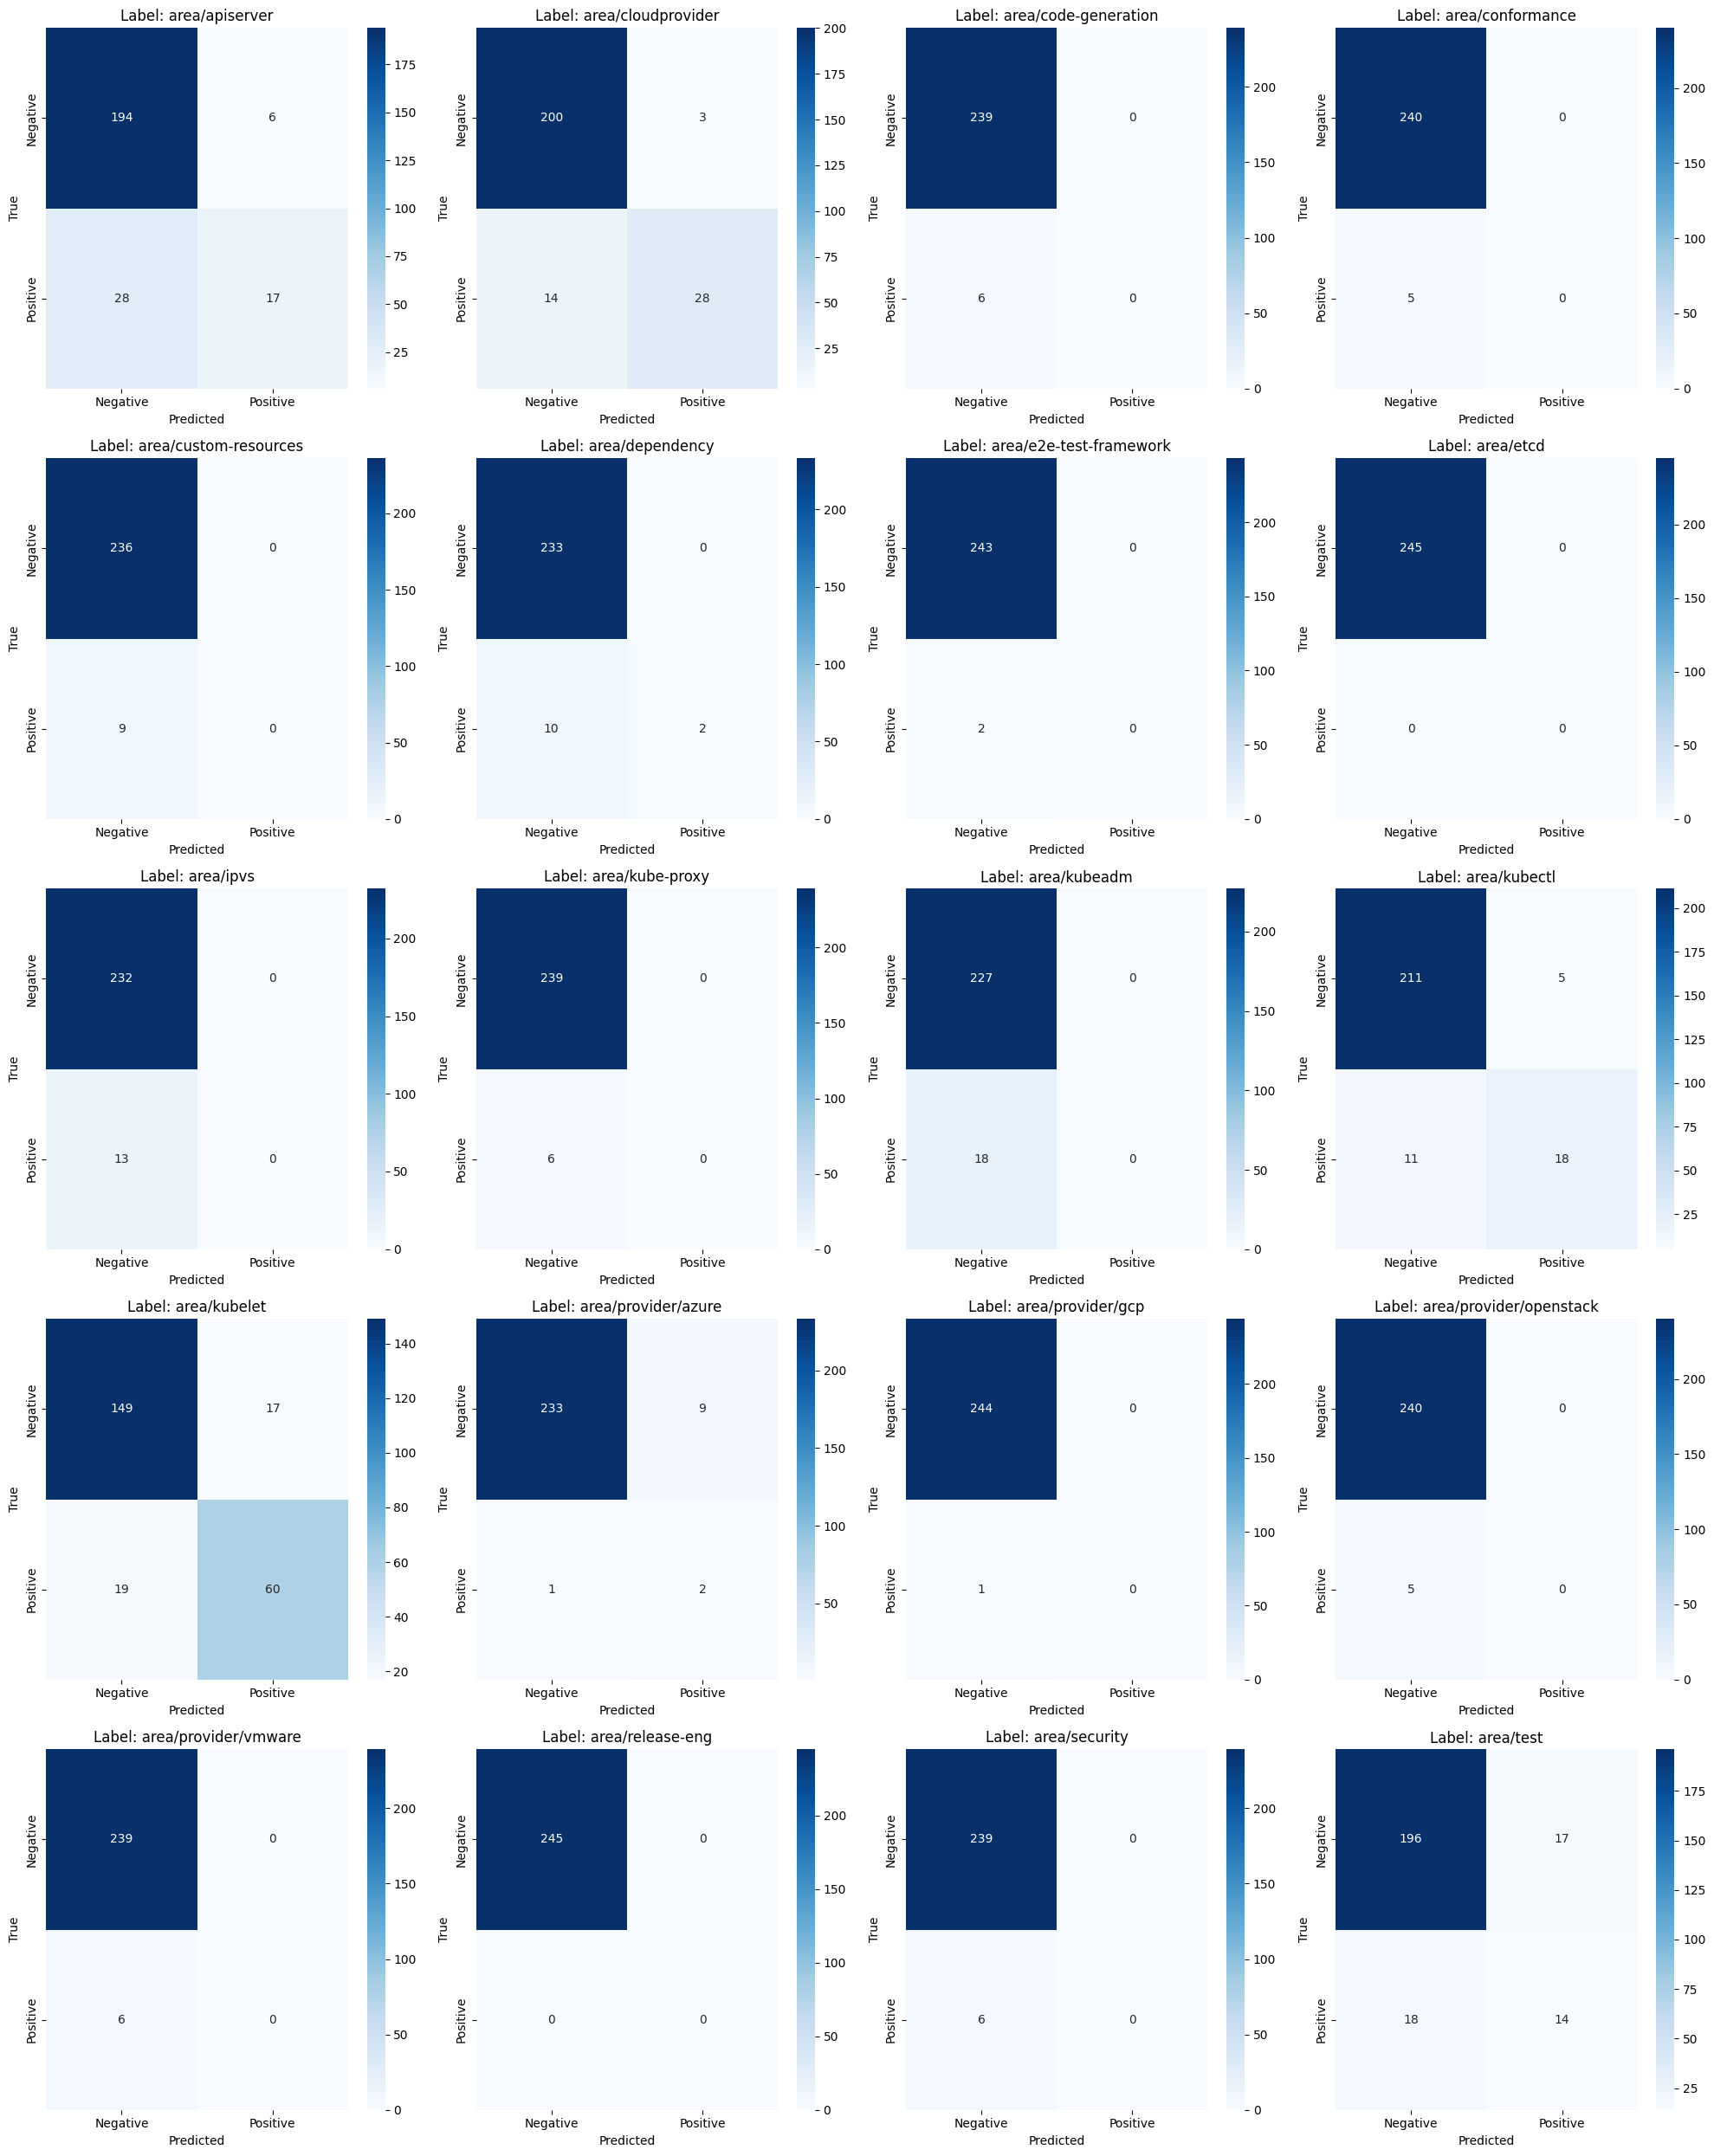

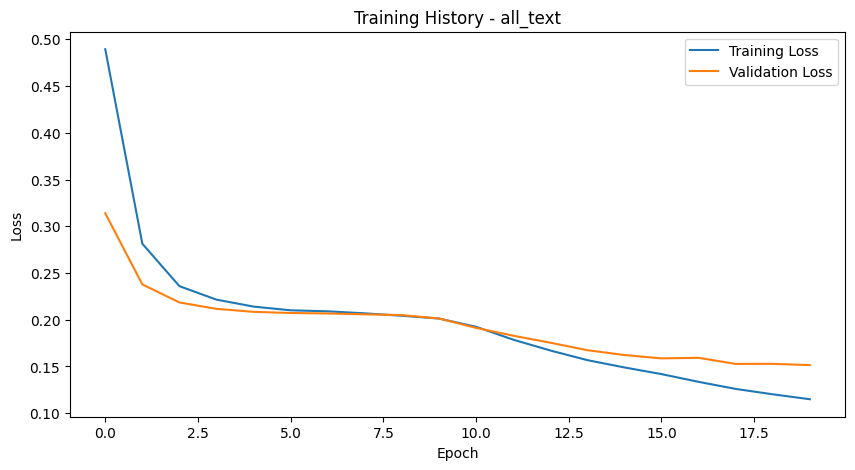

In [19]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

# Removing Most Frequent Words

## Threshold 0.5

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, count:

Training: 100%|██████████| 31/31 [00:28<00:00,  1.07it/s]


Train Loss: 0.4919, Train Accuracy (Exact Match): 0.0133
Val Loss: 0.3139
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 2/20


Training: 100%|██████████| 31/31 [00:30<00:00,  1.03it/s]


Train Loss: 0.2812, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2378
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.07it/s]


Train Loss: 0.2354, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2179
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.06it/s]


Train Loss: 0.2202, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2101
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.2100, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2029
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9353
Val Accuracy (Jaccard): 0.0024
Val Precision: 0.0082, Val Recall: 0.0024, Val F1: 0.0037
Saved new best model to ./results/run_20250310_130827_all_text_0.5/best_model_all_text_0.5.pt

Epoch 6/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1981, Train Accuracy (Exact Match): 0.0020
Val Loss: 0.2002
Val Accuracy (Exact Match): 0.0041
Val Accuracy (Hamming): 0.9365
Val Accuracy (Jaccard): 0.0260
Val Precision: 0.0374, Val Recall: 0.0337, Val F1: 0.0330
Saved new best model to ./results/run_20250310_130827_all_text_0.5/best_model_all_text_0.5.pt

Epoch 7/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.1870, Train Accuracy (Exact Match): 0.0379
Val Loss: 0.1933
Val Accuracy (Exact Match): 0.0816
Val Accuracy (Hamming): 0.9414
Val Accuracy (Jaccard): 0.1046
Val Precision: 0.1132, Val Recall: 0.1132, Val F1: 0.1104
Saved new best model to ./results/run_20250310_130827_all_text_0.5/best_model_all_text_0.5.pt

Epoch 8/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.06it/s]


Train Loss: 0.1762, Train Accuracy (Exact Match): 0.1402
Val Loss: 0.1839
Val Accuracy (Exact Match): 0.2939
Val Accuracy (Hamming): 0.9496
Val Accuracy (Jaccard): 0.3295
Val Precision: 0.3604, Val Recall: 0.3324, Val F1: 0.3402
Saved new best model to ./results/run_20250310_130827_all_text_0.5/best_model_all_text_0.5.pt

Epoch 9/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1629, Train Accuracy (Exact Match): 0.2497
Val Loss: 0.1757
Val Accuracy (Exact Match): 0.3143
Val Accuracy (Hamming): 0.9527
Val Accuracy (Jaccard): 0.3893
Val Precision: 0.4455, Val Recall: 0.4118, Val F1: 0.4141
Saved new best model to ./results/run_20250310_130827_all_text_0.5/best_model_all_text_0.5.pt

Epoch 10/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.06it/s]


Train Loss: 0.1500, Train Accuracy (Exact Match): 0.3818
Val Loss: 0.1659
Val Accuracy (Exact Match): 0.3510
Val Accuracy (Hamming): 0.9549
Val Accuracy (Jaccard): 0.4421
Val Precision: 0.5091, Val Recall: 0.4759, Val F1: 0.4727
Saved new best model to ./results/run_20250310_130827_all_text_0.5/best_model_all_text_0.5.pt

Epoch 11/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1362, Train Accuracy (Exact Match): 0.4698
Val Loss: 0.1571
Val Accuracy (Exact Match): 0.3673
Val Accuracy (Hamming): 0.9567
Val Accuracy (Jaccard): 0.4581
Val Precision: 0.5249, Val Recall: 0.4879, Val F1: 0.4885
Saved new best model to ./results/run_20250310_130827_all_text_0.5/best_model_all_text_0.5.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1257, Train Accuracy (Exact Match): 0.5271
Val Loss: 0.1459
Val Accuracy (Exact Match): 0.3918
Val Accuracy (Hamming): 0.9586
Val Accuracy (Jaccard): 0.4844
Val Precision: 0.5561, Val Recall: 0.5116, Val F1: 0.5152
Saved new best model to ./results/run_20250310_130827_all_text_0.5/best_model_all_text_0.5.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1170, Train Accuracy (Exact Match): 0.5865
Val Loss: 0.1392
Val Accuracy (Exact Match): 0.4122
Val Accuracy (Hamming): 0.9604
Val Accuracy (Jaccard): 0.5073
Val Precision: 0.5816, Val Recall: 0.5335, Val F1: 0.5391
Saved new best model to ./results/run_20250310_130827_all_text_0.5/best_model_all_text_0.5.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1071, Train Accuracy (Exact Match): 0.6018
Val Loss: 0.1368
Val Accuracy (Exact Match): 0.4327
Val Accuracy (Hamming): 0.9610
Val Accuracy (Jaccard): 0.5341
Val Precision: 0.6076, Val Recall: 0.5669, Val F1: 0.5679
Saved new best model to ./results/run_20250310_130827_all_text_0.5/best_model_all_text_0.5.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0999, Train Accuracy (Exact Match): 0.6264
Val Loss: 0.1346
Val Accuracy (Exact Match): 0.4245
Val Accuracy (Hamming): 0.9600
Val Accuracy (Jaccard): 0.5203
Val Precision: 0.5914, Val Recall: 0.5493, Val F1: 0.5528

Epoch 16/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0933, Train Accuracy (Exact Match): 0.6469
Val Loss: 0.1288
Val Accuracy (Exact Match): 0.4857
Val Accuracy (Hamming): 0.9633
Val Accuracy (Jaccard): 0.5820
Val Precision: 0.6551, Val Recall: 0.6122, Val F1: 0.6154
Saved new best model to ./results/run_20250310_130827_all_text_0.5/best_model_all_text_0.5.pt

Epoch 17/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0869, Train Accuracy (Exact Match): 0.6694
Val Loss: 0.1267
Val Accuracy (Exact Match): 0.5061
Val Accuracy (Hamming): 0.9645
Val Accuracy (Jaccard): 0.6114
Val Precision: 0.6892, Val Recall: 0.6469, Val F1: 0.6476
Saved new best model to ./results/run_20250310_130827_all_text_0.5/best_model_all_text_0.5.pt

Epoch 18/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0807, Train Accuracy (Exact Match): 0.6827
Val Loss: 0.1248
Val Accuracy (Exact Match): 0.5469
Val Accuracy (Hamming): 0.9673
Val Accuracy (Jaccard): 0.6587
Val Precision: 0.7261, Val Recall: 0.7013, Val F1: 0.6947
Saved new best model to ./results/run_20250310_130827_all_text_0.5/best_model_all_text_0.5.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0760, Train Accuracy (Exact Match): 0.7124
Val Loss: 0.1203
Val Accuracy (Exact Match): 0.5347
Val Accuracy (Hamming): 0.9665
Val Accuracy (Jaccard): 0.6450
Val Precision: 0.7173, Val Recall: 0.6845, Val F1: 0.6816

Epoch 20/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0728, Train Accuracy (Exact Match): 0.7165
Val Loss: 0.1200
Val Accuracy (Exact Match): 0.5551
Val Accuracy (Hamming): 0.9680
Val Accuracy (Jaccard): 0.6767
Val Precision: 0.7394, Val Recall: 0.7326, Val F1: 0.7162
Saved new best model to ./results/run_20250310_130827_all_text_0.5/best_model_all_text_0.5.pt

Loading best model for final evaluation...


<ipython-input-10-1ee0104d141d>:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.5551
Hamming Accuracy: 0.9680
Jaccard Similarity: 0.6767
Precision: 0.7394
Recall: 0.7326
F1 Score: 0.7162

Training completed! Results saved to ./results/run_20250310_130827_all_text_0.5


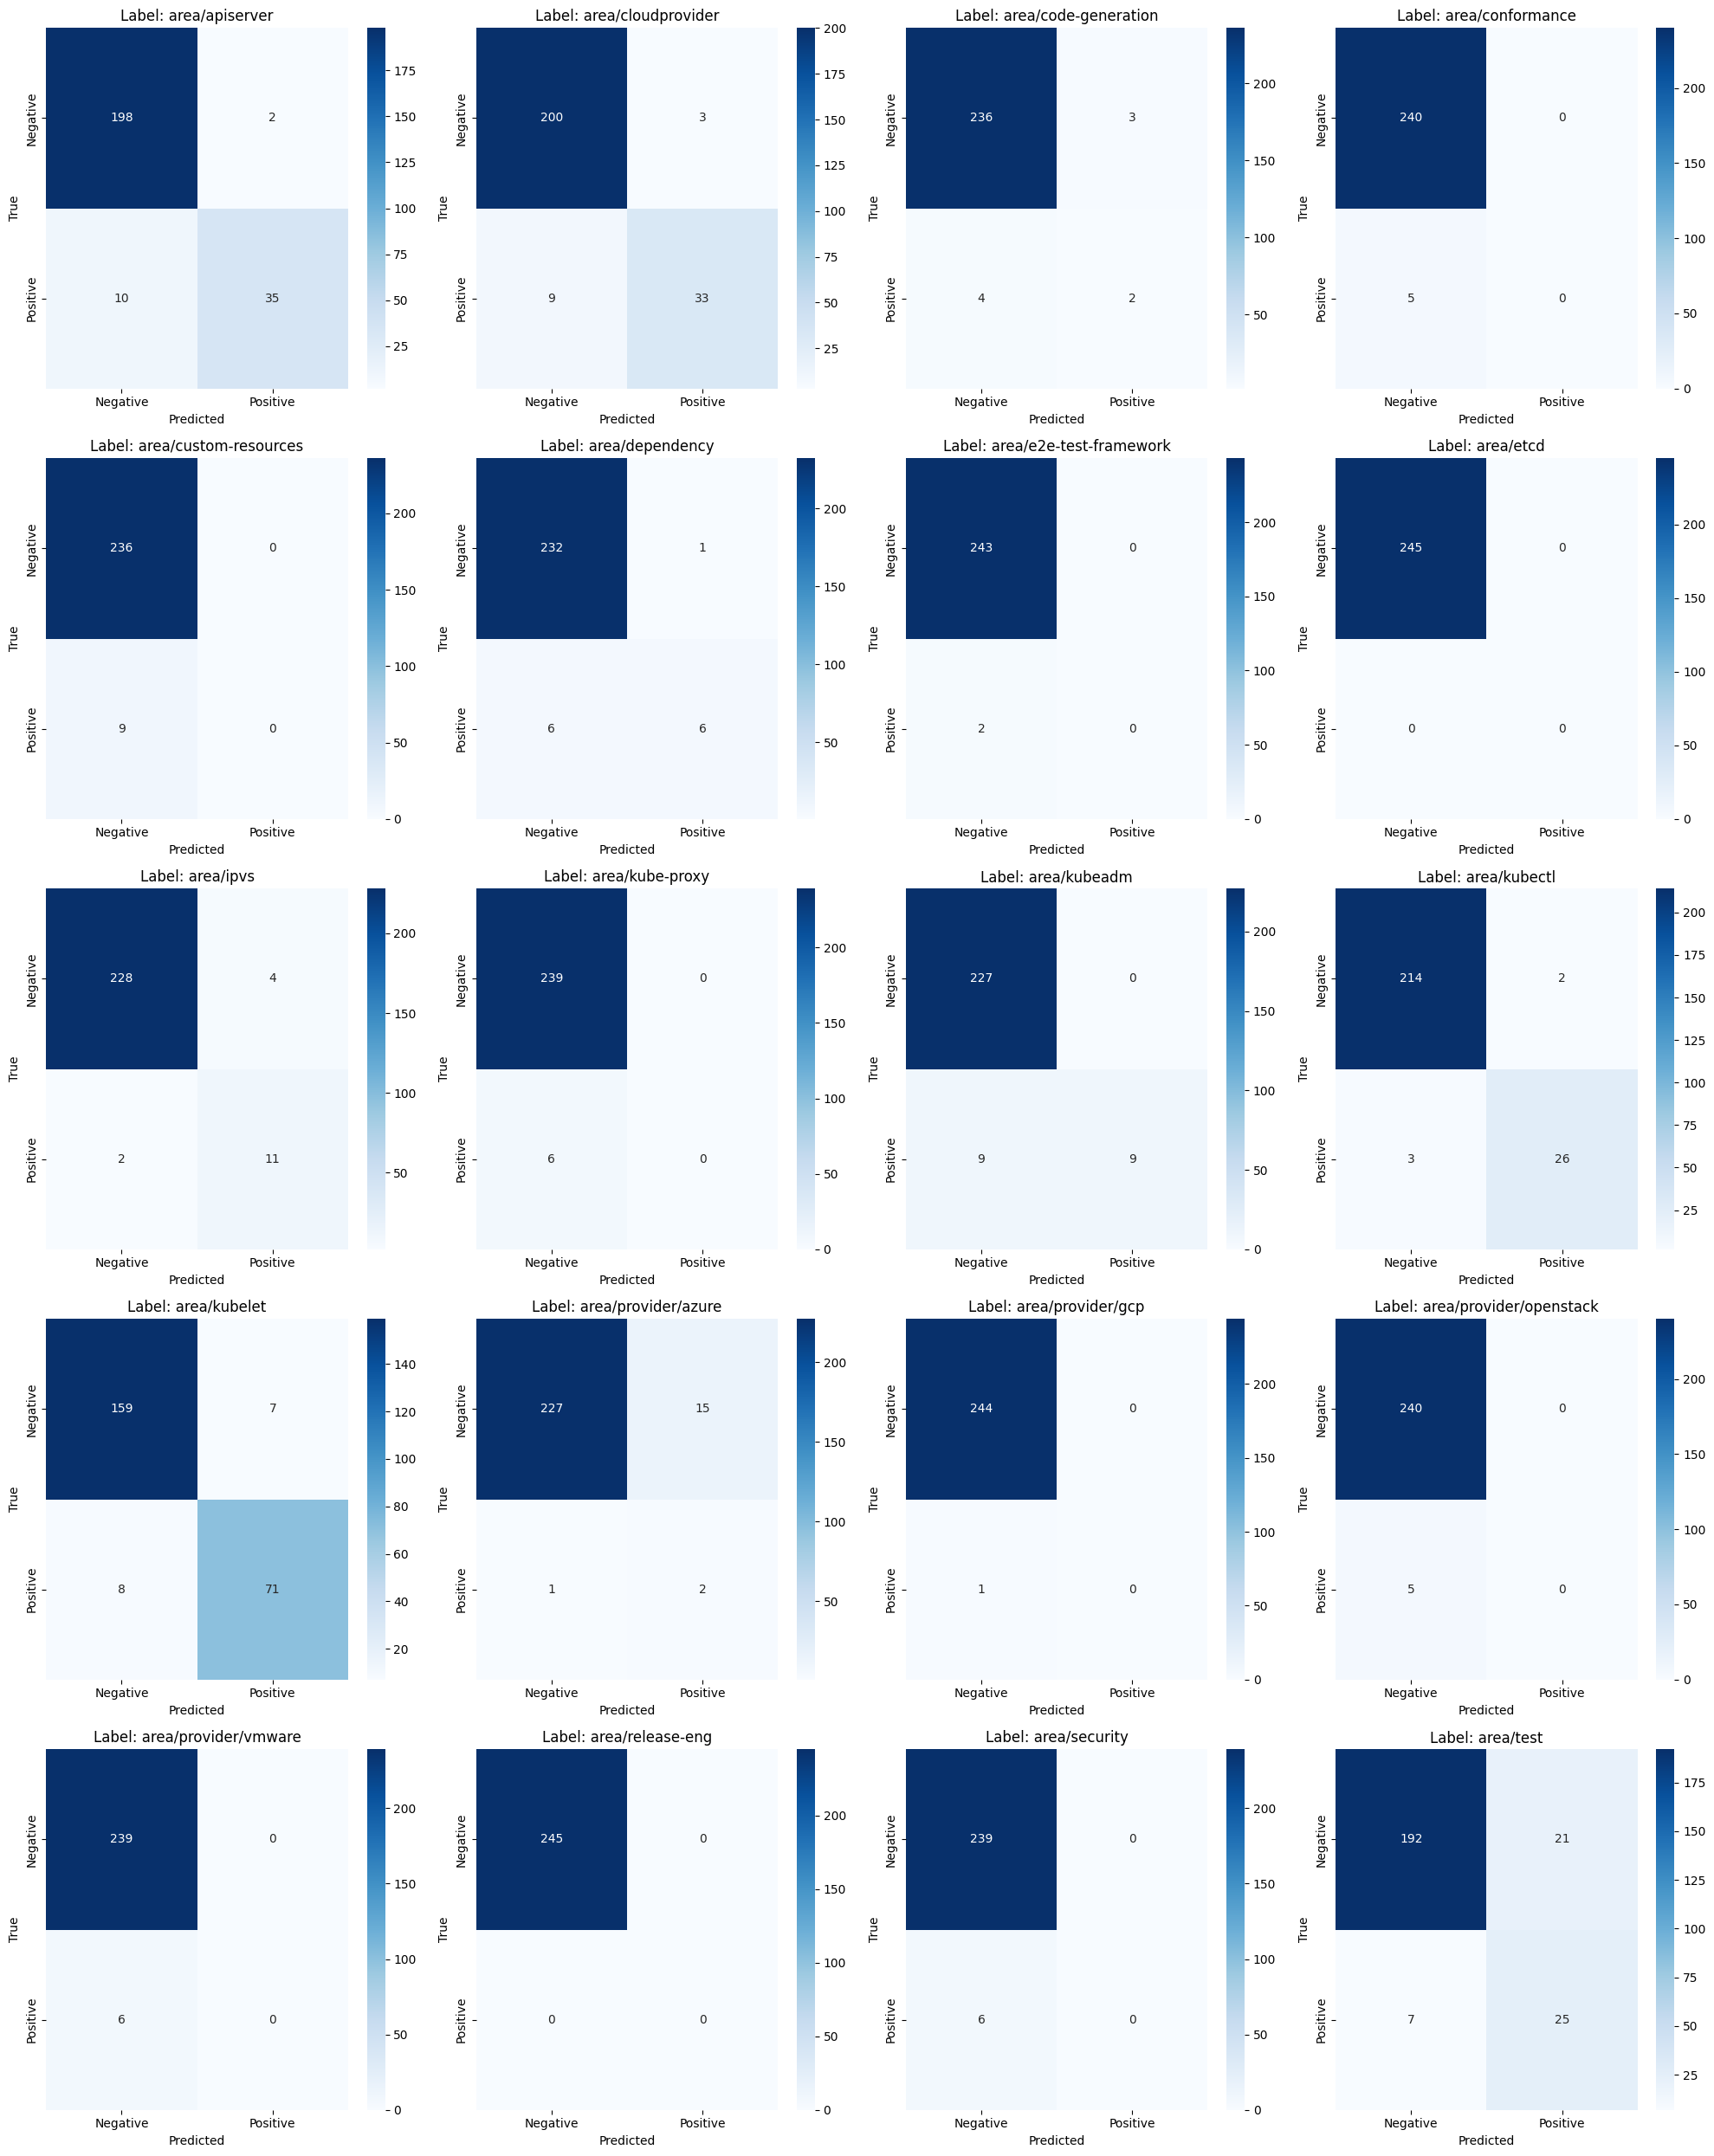

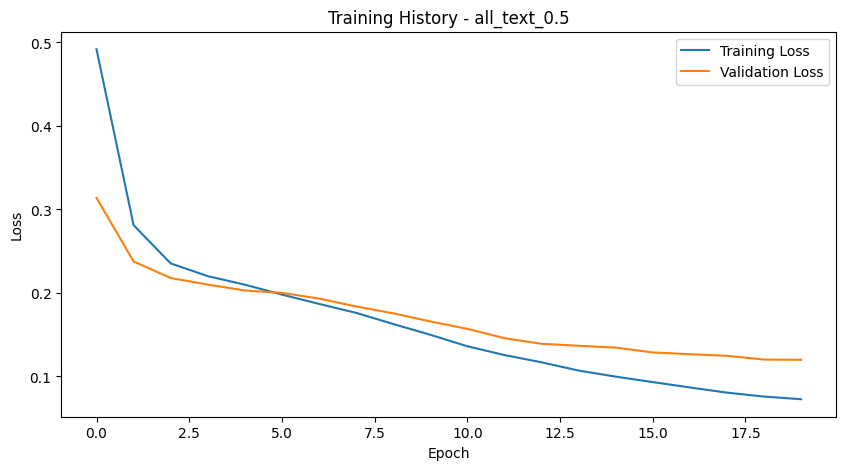

In [12]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

## Threshold 0.6

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, count:

Training: 100%|██████████| 31/31 [00:30<00:00,  1.03it/s]


Train Loss: 0.4918, Train Accuracy (Exact Match): 0.0123
Val Loss: 0.3139
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 2/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.2812, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2378
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.07it/s]


Train Loss: 0.2354, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2180
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.2202, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2101
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.06it/s]


Train Loss: 0.2100, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2029
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9353
Val Accuracy (Jaccard): 0.0024
Val Precision: 0.0082, Val Recall: 0.0024, Val F1: 0.0037
Saved new best model to ./results/run_20250310_132033_all_text_0.6/best_model_all_text_0.6.pt

Epoch 6/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1982, Train Accuracy (Exact Match): 0.0031
Val Loss: 0.1999
Val Accuracy (Exact Match): 0.0041
Val Accuracy (Hamming): 0.9363
Val Accuracy (Jaccard): 0.0236
Val Precision: 0.0340, Val Recall: 0.0282, Val F1: 0.0293
Saved new best model to ./results/run_20250310_132033_all_text_0.6/best_model_all_text_0.6.pt

Epoch 7/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1871, Train Accuracy (Exact Match): 0.0348
Val Loss: 0.1935
Val Accuracy (Exact Match): 0.0531
Val Accuracy (Hamming): 0.9398
Val Accuracy (Jaccard): 0.0739
Val Precision: 0.0805, Val Recall: 0.0826, Val F1: 0.0791
Saved new best model to ./results/run_20250310_132033_all_text_0.6/best_model_all_text_0.6.pt

Epoch 8/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1764, Train Accuracy (Exact Match): 0.1372
Val Loss: 0.1839
Val Accuracy (Exact Match): 0.2898
Val Accuracy (Hamming): 0.9504
Val Accuracy (Jaccard): 0.3304
Val Precision: 0.3659, Val Recall: 0.3359, Val F1: 0.3431
Saved new best model to ./results/run_20250310_132033_all_text_0.6/best_model_all_text_0.6.pt

Epoch 9/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.06it/s]


Train Loss: 0.1627, Train Accuracy (Exact Match): 0.2508
Val Loss: 0.1763
Val Accuracy (Exact Match): 0.3224
Val Accuracy (Hamming): 0.9535
Val Accuracy (Jaccard): 0.4056
Val Precision: 0.4673, Val Recall: 0.4322, Val F1: 0.4331
Saved new best model to ./results/run_20250310_132033_all_text_0.6/best_model_all_text_0.6.pt

Epoch 10/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1499, Train Accuracy (Exact Match): 0.3777
Val Loss: 0.1662
Val Accuracy (Exact Match): 0.3347
Val Accuracy (Hamming): 0.9545
Val Accuracy (Jaccard): 0.4343
Val Precision: 0.5013, Val Recall: 0.4759, Val F1: 0.4677
Saved new best model to ./results/run_20250310_132033_all_text_0.6/best_model_all_text_0.6.pt

Epoch 11/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.06it/s]


Train Loss: 0.1371, Train Accuracy (Exact Match): 0.4637
Val Loss: 0.1591
Val Accuracy (Exact Match): 0.3510
Val Accuracy (Hamming): 0.9555
Val Accuracy (Jaccard): 0.4499
Val Precision: 0.5194, Val Recall: 0.4852, Val F1: 0.4828
Saved new best model to ./results/run_20250310_132033_all_text_0.6/best_model_all_text_0.6.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1266, Train Accuracy (Exact Match): 0.5148
Val Loss: 0.1487
Val Accuracy (Exact Match): 0.3592
Val Accuracy (Hamming): 0.9569
Val Accuracy (Jaccard): 0.4621
Val Precision: 0.5337, Val Recall: 0.4981, Val F1: 0.4964
Saved new best model to ./results/run_20250310_132033_all_text_0.6/best_model_all_text_0.6.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1175, Train Accuracy (Exact Match): 0.5752
Val Loss: 0.1404
Val Accuracy (Exact Match): 0.3837
Val Accuracy (Hamming): 0.9584
Val Accuracy (Jaccard): 0.4848
Val Precision: 0.5551, Val Recall: 0.5211, Val F1: 0.5184
Saved new best model to ./results/run_20250310_132033_all_text_0.6/best_model_all_text_0.6.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1075, Train Accuracy (Exact Match): 0.5977
Val Loss: 0.1382
Val Accuracy (Exact Match): 0.4163
Val Accuracy (Hamming): 0.9594
Val Accuracy (Jaccard): 0.5252
Val Precision: 0.5950, Val Recall: 0.5682, Val F1: 0.5615
Saved new best model to ./results/run_20250310_132033_all_text_0.6/best_model_all_text_0.6.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1001, Train Accuracy (Exact Match): 0.6315
Val Loss: 0.1351
Val Accuracy (Exact Match): 0.4449
Val Accuracy (Hamming): 0.9610
Val Accuracy (Jaccard): 0.5399
Val Precision: 0.6178, Val Recall: 0.5653, Val F1: 0.5727
Saved new best model to ./results/run_20250310_132033_all_text_0.6/best_model_all_text_0.6.pt

Epoch 16/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0936, Train Accuracy (Exact Match): 0.6479
Val Loss: 0.1295
Val Accuracy (Exact Match): 0.4898
Val Accuracy (Hamming): 0.9633
Val Accuracy (Jaccard): 0.5868
Val Precision: 0.6612, Val Recall: 0.6136, Val F1: 0.6193
Saved new best model to ./results/run_20250310_132033_all_text_0.6/best_model_all_text_0.6.pt

Epoch 17/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0875, Train Accuracy (Exact Match): 0.6663
Val Loss: 0.1267
Val Accuracy (Exact Match): 0.4735
Val Accuracy (Hamming): 0.9627
Val Accuracy (Jaccard): 0.5746
Val Precision: 0.6510, Val Recall: 0.6034, Val F1: 0.6084

Epoch 18/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0817, Train Accuracy (Exact Match): 0.6837
Val Loss: 0.1261
Val Accuracy (Exact Match): 0.5551
Val Accuracy (Hamming): 0.9665
Val Accuracy (Jaccard): 0.6593
Val Precision: 0.7282, Val Recall: 0.6971, Val F1: 0.6943
Saved new best model to ./results/run_20250310_132033_all_text_0.6/best_model_all_text_0.6.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0767, Train Accuracy (Exact Match): 0.7083
Val Loss: 0.1217
Val Accuracy (Exact Match): 0.5224
Val Accuracy (Hamming): 0.9655
Val Accuracy (Jaccard): 0.6355
Val Precision: 0.7109, Val Recall: 0.6782, Val F1: 0.6736

Epoch 20/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0728, Train Accuracy (Exact Match): 0.7247
Val Loss: 0.1227
Val Accuracy (Exact Match): 0.5469
Val Accuracy (Hamming): 0.9653
Val Accuracy (Jaccard): 0.6687
Val Precision: 0.7322, Val Recall: 0.7277, Val F1: 0.7091
Saved new best model to ./results/run_20250310_132033_all_text_0.6/best_model_all_text_0.6.pt

Loading best model for final evaluation...


<ipython-input-10-1ee0104d141d>:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.5469
Hamming Accuracy: 0.9653
Jaccard Similarity: 0.6687
Precision: 0.7322
Recall: 0.7277
F1 Score: 0.7091

Training completed! Results saved to ./results/run_20250310_132033_all_text_0.6


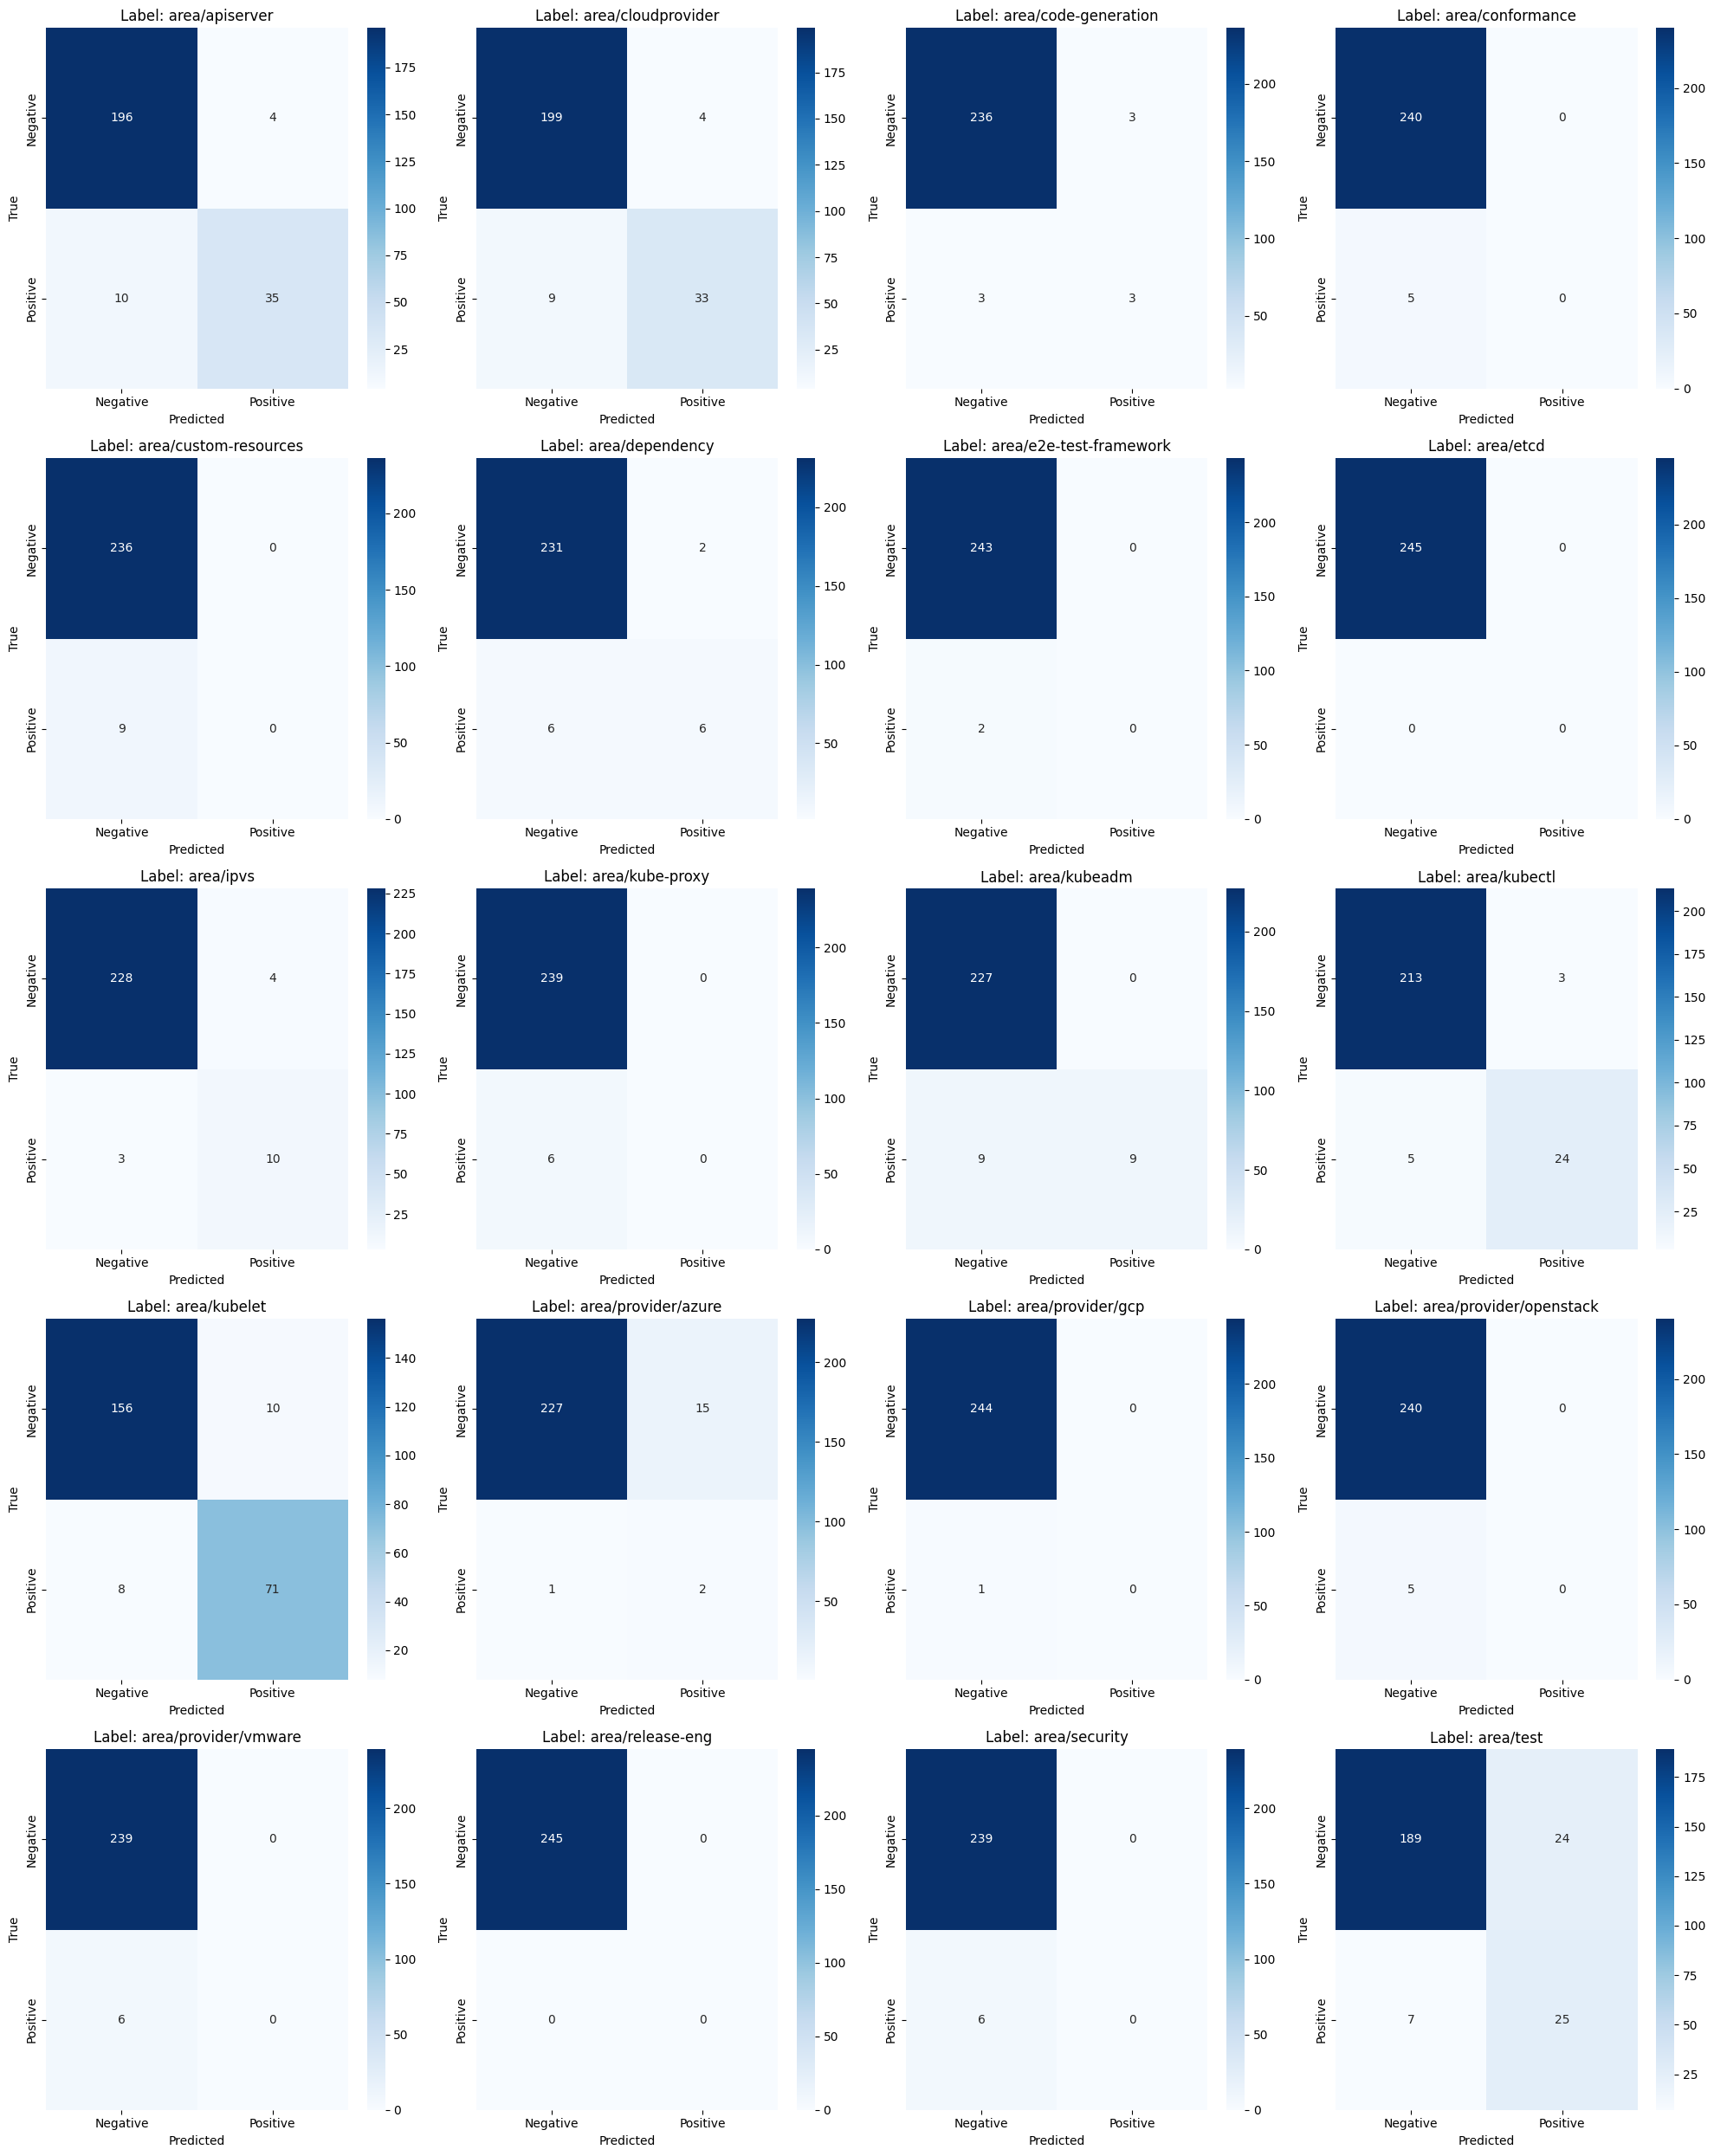

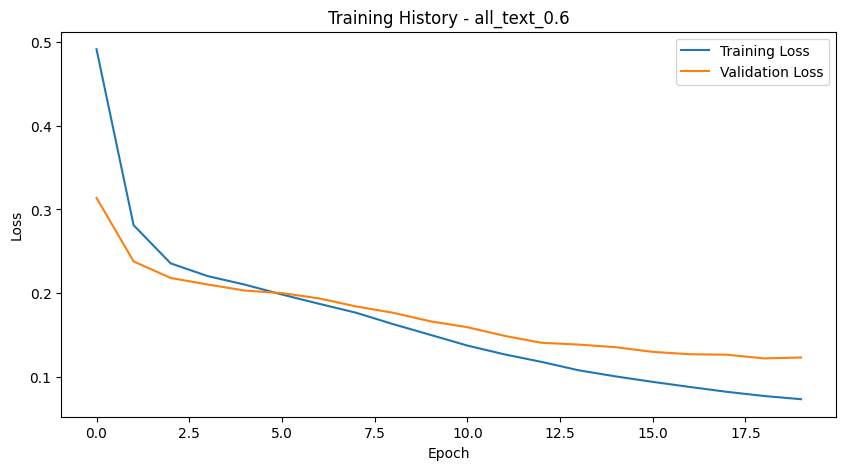

In [13]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.6',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

## Threshold 0.7

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, count:

Training: 100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Train Loss: 0.4915, Train Accuracy (Exact Match): 0.0123
Val Loss: 0.3137
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 2/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.03it/s]


Train Loss: 0.2811, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2378
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.06it/s]


Train Loss: 0.2355, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2179
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.2203, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2102
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.2105, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2030
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9351
Val Accuracy (Jaccard): 0.0010
Val Precision: 0.0041, Val Recall: 0.0010, Val F1: 0.0016
Saved new best model to ./results/run_20250310_133239_all_text_0.7/best_model_all_text_0.7.pt

Epoch 6/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.1991, Train Accuracy (Exact Match): 0.0020
Val Loss: 0.1997
Val Accuracy (Exact Match): 0.0082
Val Accuracy (Hamming): 0.9369
Val Accuracy (Jaccard): 0.0267
Val Precision: 0.0381, Val Recall: 0.0296, Val F1: 0.0323
Saved new best model to ./results/run_20250310_133239_all_text_0.7/best_model_all_text_0.7.pt

Epoch 7/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1882, Train Accuracy (Exact Match): 0.0266
Val Loss: 0.1930
Val Accuracy (Exact Match): 0.0245
Val Accuracy (Hamming): 0.9388
Val Accuracy (Jaccard): 0.0392
Val Precision: 0.0410, Val Recall: 0.0424, Val F1: 0.0415
Saved new best model to ./results/run_20250310_133239_all_text_0.7/best_model_all_text_0.7.pt

Epoch 8/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1772, Train Accuracy (Exact Match): 0.1238
Val Loss: 0.1839
Val Accuracy (Exact Match): 0.2816
Val Accuracy (Hamming): 0.9508
Val Accuracy (Jaccard): 0.3146
Val Precision: 0.3480, Val Recall: 0.3172, Val F1: 0.3254
Saved new best model to ./results/run_20250310_133239_all_text_0.7/best_model_all_text_0.7.pt

Epoch 9/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1628, Train Accuracy (Exact Match): 0.2518
Val Loss: 0.1738
Val Accuracy (Exact Match): 0.3469
Val Accuracy (Hamming): 0.9555
Val Accuracy (Jaccard): 0.4220
Val Precision: 0.4869, Val Recall: 0.4371, Val F1: 0.4465
Saved new best model to ./results/run_20250310_133239_all_text_0.7/best_model_all_text_0.7.pt

Epoch 10/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1489, Train Accuracy (Exact Match): 0.3910
Val Loss: 0.1657
Val Accuracy (Exact Match): 0.3388
Val Accuracy (Hamming): 0.9553
Val Accuracy (Jaccard): 0.4392
Val Precision: 0.5016, Val Recall: 0.4782, Val F1: 0.4718
Saved new best model to ./results/run_20250310_133239_all_text_0.7/best_model_all_text_0.7.pt

Epoch 11/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1363, Train Accuracy (Exact Match): 0.4555
Val Loss: 0.1568
Val Accuracy (Exact Match): 0.3510
Val Accuracy (Hamming): 0.9559
Val Accuracy (Jaccard): 0.4403
Val Precision: 0.5068, Val Recall: 0.4707, Val F1: 0.4710

Epoch 12/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.1251, Train Accuracy (Exact Match): 0.5015
Val Loss: 0.1480
Val Accuracy (Exact Match): 0.3673
Val Accuracy (Hamming): 0.9584
Val Accuracy (Jaccard): 0.4683
Val Precision: 0.5398, Val Recall: 0.5030, Val F1: 0.5022
Saved new best model to ./results/run_20250310_133239_all_text_0.7/best_model_all_text_0.7.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.1160, Train Accuracy (Exact Match): 0.5803
Val Loss: 0.1389
Val Accuracy (Exact Match): 0.3959
Val Accuracy (Hamming): 0.9590
Val Accuracy (Jaccard): 0.4947
Val Precision: 0.5639, Val Recall: 0.5293, Val F1: 0.5280
Saved new best model to ./results/run_20250310_133239_all_text_0.7/best_model_all_text_0.7.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1066, Train Accuracy (Exact Match): 0.6111
Val Loss: 0.1373
Val Accuracy (Exact Match): 0.4122
Val Accuracy (Hamming): 0.9594
Val Accuracy (Jaccard): 0.5153
Val Precision: 0.5863, Val Recall: 0.5556, Val F1: 0.5507
Saved new best model to ./results/run_20250310_133239_all_text_0.7/best_model_all_text_0.7.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0991, Train Accuracy (Exact Match): 0.6346
Val Loss: 0.1332
Val Accuracy (Exact Match): 0.4653
Val Accuracy (Hamming): 0.9614
Val Accuracy (Jaccard): 0.5607
Val Precision: 0.6339, Val Recall: 0.5873, Val F1: 0.5932
Saved new best model to ./results/run_20250310_133239_all_text_0.7/best_model_all_text_0.7.pt

Epoch 16/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0922, Train Accuracy (Exact Match): 0.6581
Val Loss: 0.1306
Val Accuracy (Exact Match): 0.5102
Val Accuracy (Hamming): 0.9635
Val Accuracy (Jaccard): 0.6086
Val Precision: 0.6816, Val Recall: 0.6408, Val F1: 0.6426
Saved new best model to ./results/run_20250310_133239_all_text_0.7/best_model_all_text_0.7.pt

Epoch 17/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0864, Train Accuracy (Exact Match): 0.6653
Val Loss: 0.1276
Val Accuracy (Exact Match): 0.5143
Val Accuracy (Hamming): 0.9633
Val Accuracy (Jaccard): 0.6131
Val Precision: 0.6844, Val Recall: 0.6456, Val F1: 0.6470
Saved new best model to ./results/run_20250310_133239_all_text_0.7/best_model_all_text_0.7.pt

Epoch 18/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0808, Train Accuracy (Exact Match): 0.6899
Val Loss: 0.1247
Val Accuracy (Exact Match): 0.5429
Val Accuracy (Hamming): 0.9645
Val Accuracy (Jaccard): 0.6424
Val Precision: 0.7094, Val Recall: 0.6794, Val F1: 0.6762
Saved new best model to ./results/run_20250310_133239_all_text_0.7/best_model_all_text_0.7.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0764, Train Accuracy (Exact Match): 0.7083
Val Loss: 0.1221
Val Accuracy (Exact Match): 0.5469
Val Accuracy (Hamming): 0.9655
Val Accuracy (Jaccard): 0.6518
Val Precision: 0.7221, Val Recall: 0.6886, Val F1: 0.6872
Saved new best model to ./results/run_20250310_133239_all_text_0.7/best_model_all_text_0.7.pt

Epoch 20/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0726, Train Accuracy (Exact Match): 0.7155
Val Loss: 0.1230
Val Accuracy (Exact Match): 0.5510
Val Accuracy (Hamming): 0.9651
Val Accuracy (Jaccard): 0.6675
Val Precision: 0.7243, Val Recall: 0.7273, Val F1: 0.7062
Saved new best model to ./results/run_20250310_133239_all_text_0.7/best_model_all_text_0.7.pt

Loading best model for final evaluation...


<ipython-input-10-1ee0104d141d>:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.5510
Hamming Accuracy: 0.9651
Jaccard Similarity: 0.6675
Precision: 0.7243
Recall: 0.7273
F1 Score: 0.7062

Training completed! Results saved to ./results/run_20250310_133239_all_text_0.7


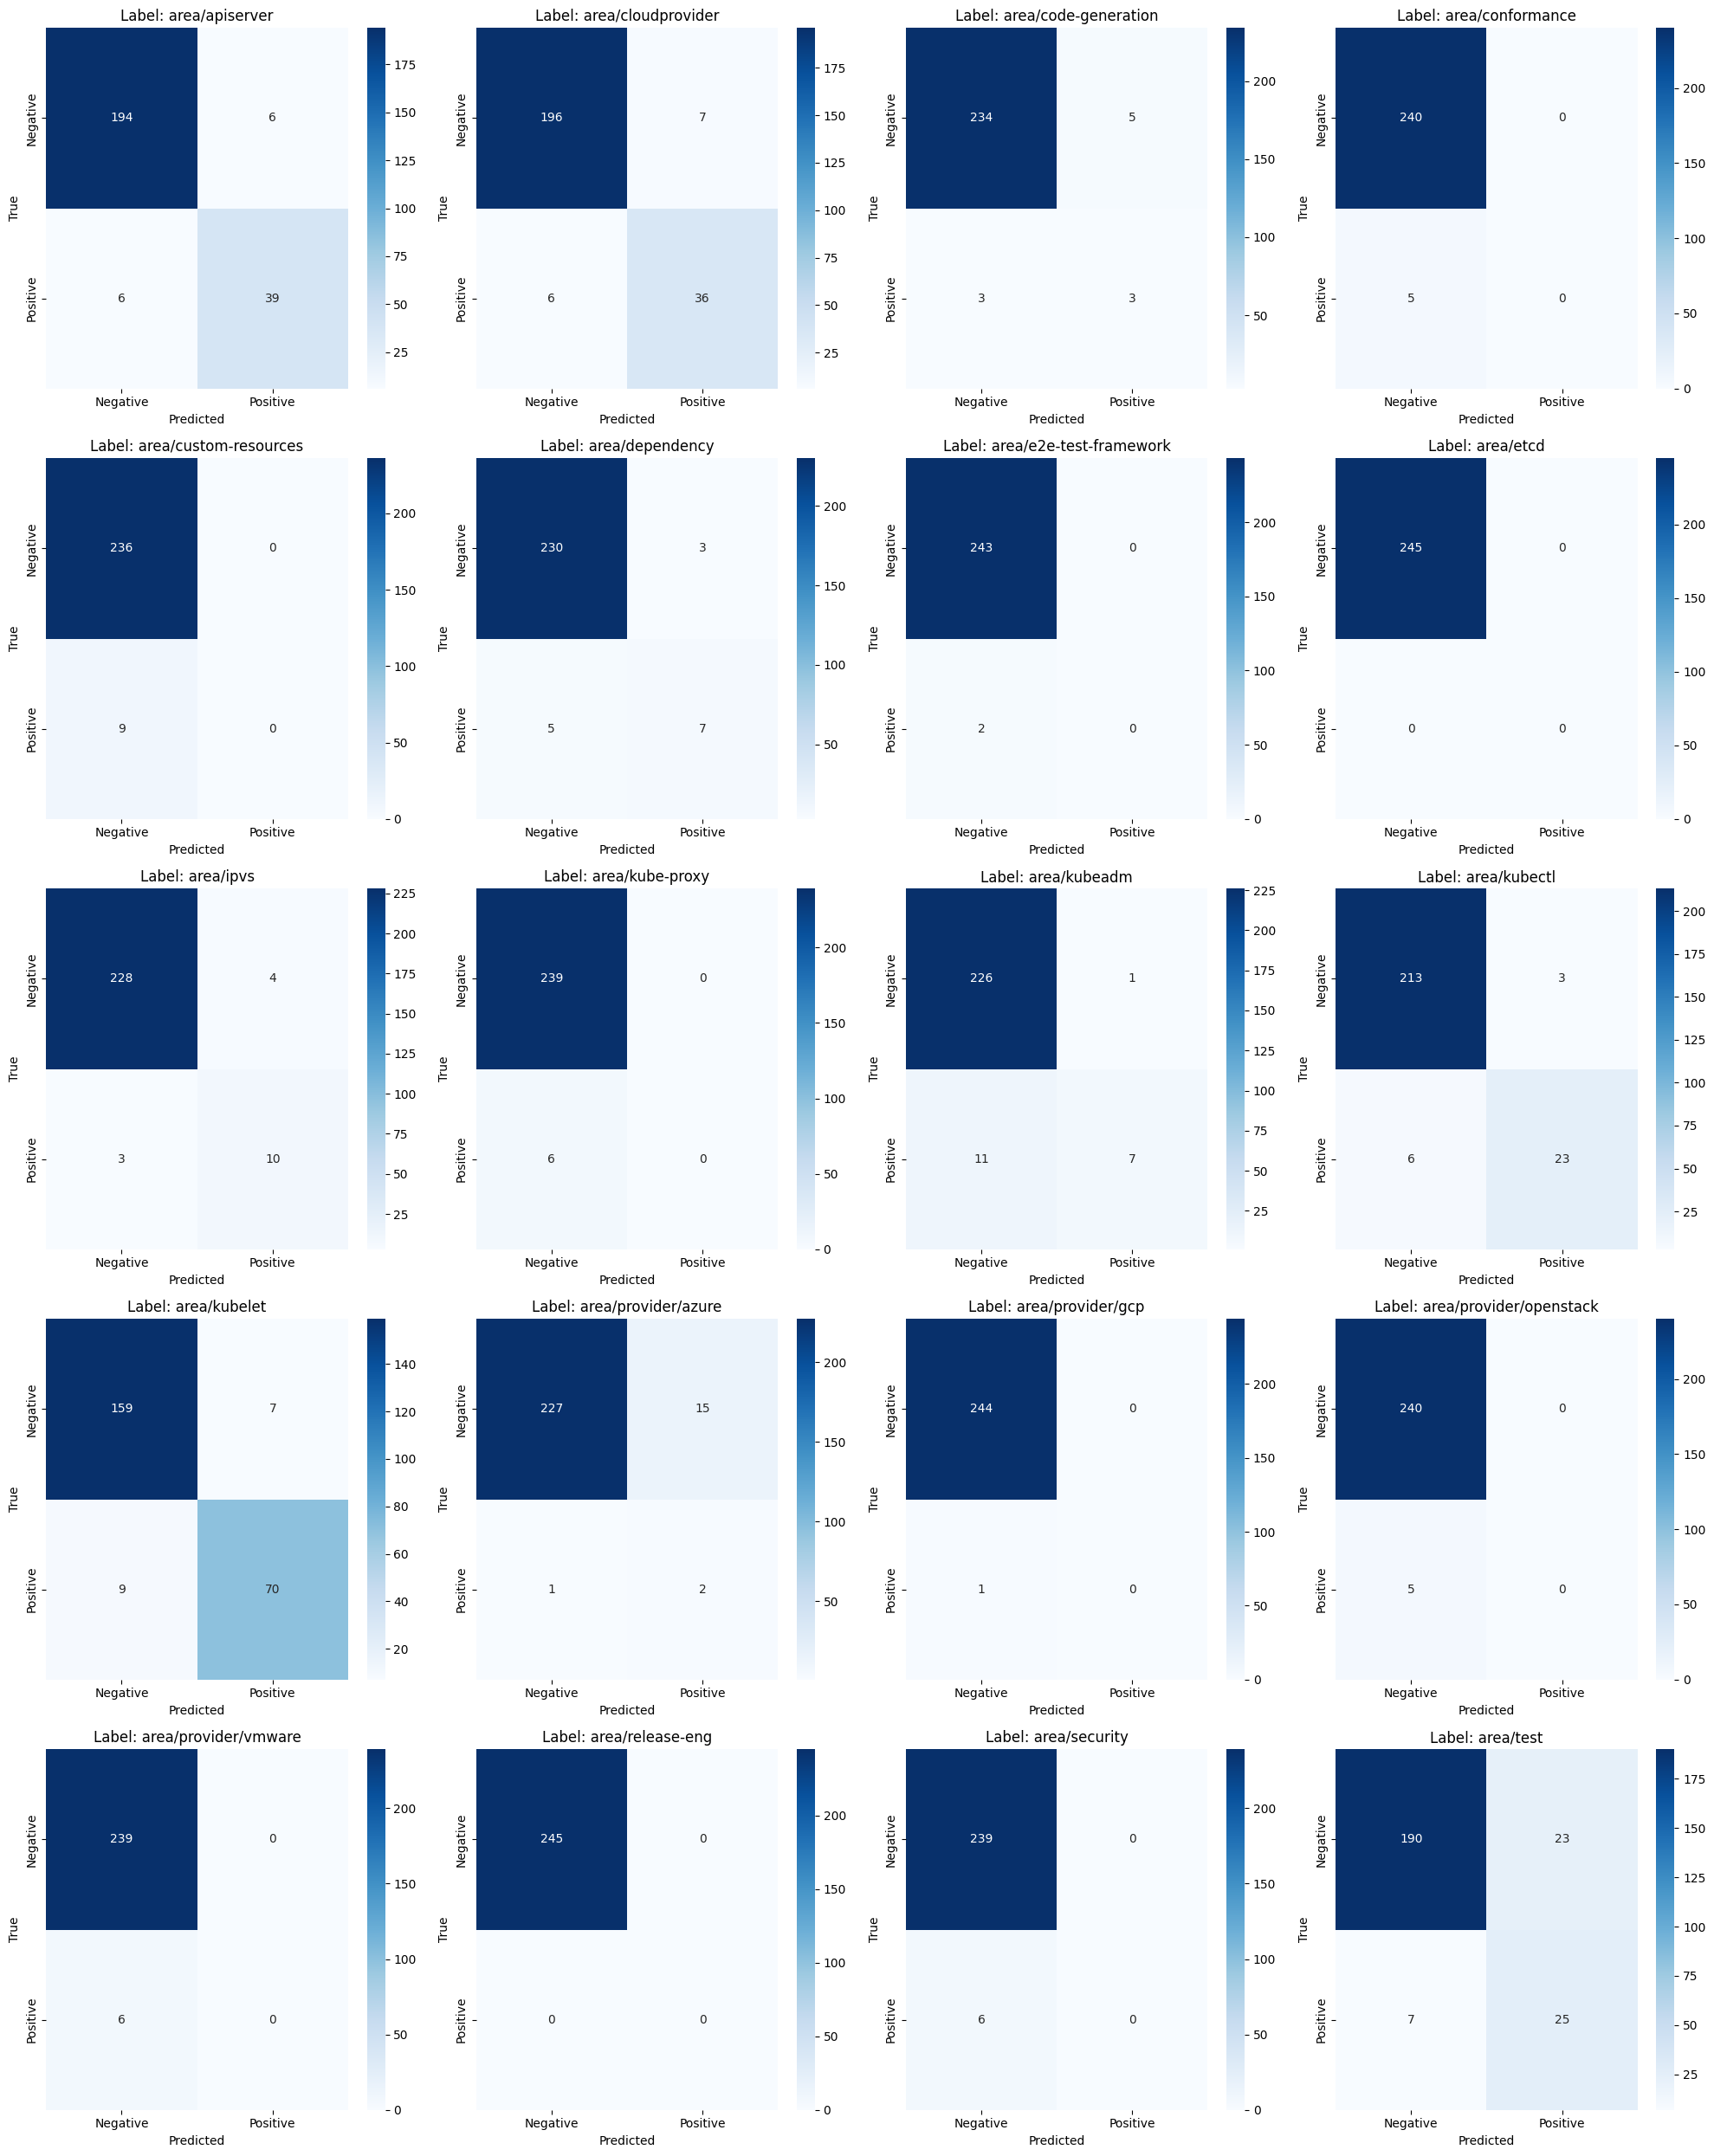

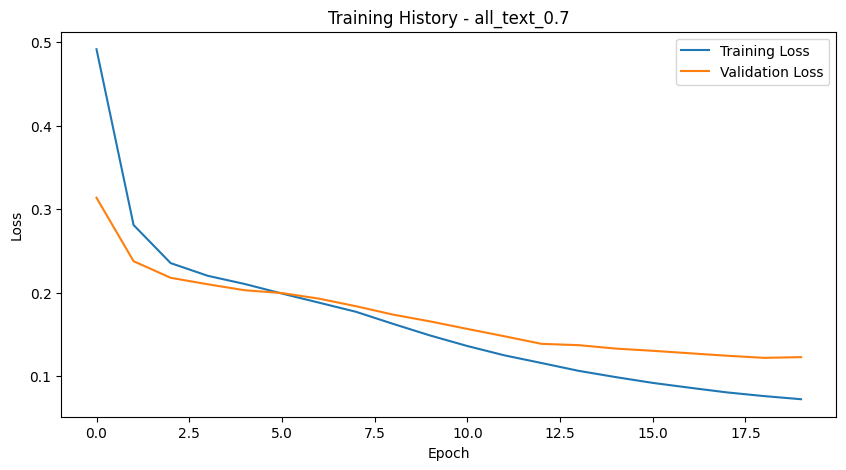

In [14]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.7',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

## Threshold 0.8

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, count:

Training: 100%|██████████| 31/31 [00:30<00:00,  1.02it/s]


Train Loss: 0.4916, Train Accuracy (Exact Match): 0.0123
Val Loss: 0.3140
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 2/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.2811, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2378
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.06it/s]


Train Loss: 0.2355, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2179
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.2204, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2102
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.2106, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2031
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9351
Val Accuracy (Jaccard): 0.0010
Val Precision: 0.0041, Val Recall: 0.0010, Val F1: 0.0016
Saved new best model to ./results/run_20250310_134450_all_text_0.8/best_model_all_text_0.8.pt

Epoch 6/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.1992, Train Accuracy (Exact Match): 0.0010
Val Loss: 0.1997
Val Accuracy (Exact Match): 0.0082
Val Accuracy (Hamming): 0.9365
Val Accuracy (Jaccard): 0.0256
Val Precision: 0.0361, Val Recall: 0.0282, Val F1: 0.0307
Saved new best model to ./results/run_20250310_134450_all_text_0.8/best_model_all_text_0.8.pt

Epoch 7/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1885, Train Accuracy (Exact Match): 0.0256
Val Loss: 0.1933
Val Accuracy (Exact Match): 0.0408
Val Accuracy (Hamming): 0.9396
Val Accuracy (Jaccard): 0.0576
Val Precision: 0.0594, Val Recall: 0.0629, Val F1: 0.0605
Saved new best model to ./results/run_20250310_134450_all_text_0.8/best_model_all_text_0.8.pt

Epoch 8/20


Training: 100%|██████████| 31/31 [00:30<00:00,  1.03it/s]


Train Loss: 0.1775, Train Accuracy (Exact Match): 0.1187
Val Loss: 0.1844
Val Accuracy (Exact Match): 0.2857
Val Accuracy (Hamming): 0.9502
Val Accuracy (Jaccard): 0.3201
Val Precision: 0.3522, Val Recall: 0.3230, Val F1: 0.3307
Saved new best model to ./results/run_20250310_134450_all_text_0.8/best_model_all_text_0.8.pt

Epoch 9/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1634, Train Accuracy (Exact Match): 0.2559
Val Loss: 0.1743
Val Accuracy (Exact Match): 0.3265
Val Accuracy (Hamming): 0.9545
Val Accuracy (Jaccard): 0.3981
Val Precision: 0.4598, Val Recall: 0.4118, Val F1: 0.4216
Saved new best model to ./results/run_20250310_134450_all_text_0.8/best_model_all_text_0.8.pt

Epoch 10/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.1497, Train Accuracy (Exact Match): 0.3838
Val Loss: 0.1655
Val Accuracy (Exact Match): 0.3429
Val Accuracy (Hamming): 0.9549
Val Accuracy (Jaccard): 0.4399
Val Precision: 0.5006, Val Recall: 0.4794, Val F1: 0.4720
Saved new best model to ./results/run_20250310_134450_all_text_0.8/best_model_all_text_0.8.pt

Epoch 11/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1366, Train Accuracy (Exact Match): 0.4637
Val Loss: 0.1558
Val Accuracy (Exact Match): 0.3510
Val Accuracy (Hamming): 0.9563
Val Accuracy (Jaccard): 0.4510
Val Precision: 0.5214, Val Recall: 0.4842, Val F1: 0.4839
Saved new best model to ./results/run_20250310_134450_all_text_0.8/best_model_all_text_0.8.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1252, Train Accuracy (Exact Match): 0.5056
Val Loss: 0.1469
Val Accuracy (Exact Match): 0.3755
Val Accuracy (Hamming): 0.9580
Val Accuracy (Jaccard): 0.4809
Val Precision: 0.5527, Val Recall: 0.5185, Val F1: 0.5159
Saved new best model to ./results/run_20250310_134450_all_text_0.8/best_model_all_text_0.8.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1159, Train Accuracy (Exact Match): 0.5844
Val Loss: 0.1378
Val Accuracy (Exact Match): 0.4163
Val Accuracy (Hamming): 0.9602
Val Accuracy (Jaccard): 0.5106
Val Precision: 0.5816, Val Recall: 0.5395, Val F1: 0.5422
Saved new best model to ./results/run_20250310_134450_all_text_0.8/best_model_all_text_0.8.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1062, Train Accuracy (Exact Match): 0.6141
Val Loss: 0.1360
Val Accuracy (Exact Match): 0.4286
Val Accuracy (Hamming): 0.9600
Val Accuracy (Jaccard): 0.5331
Val Precision: 0.6061, Val Recall: 0.5714, Val F1: 0.5691
Saved new best model to ./results/run_20250310_134450_all_text_0.8/best_model_all_text_0.8.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0993, Train Accuracy (Exact Match): 0.6356
Val Loss: 0.1329
Val Accuracy (Exact Match): 0.4286
Val Accuracy (Hamming): 0.9592
Val Accuracy (Jaccard): 0.5215
Val Precision: 0.5939, Val Recall: 0.5490, Val F1: 0.5541

Epoch 16/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0922, Train Accuracy (Exact Match): 0.6592
Val Loss: 0.1285
Val Accuracy (Exact Match): 0.5184
Val Accuracy (Hamming): 0.9641
Val Accuracy (Jaccard): 0.6147
Val Precision: 0.6898, Val Recall: 0.6429, Val F1: 0.6480
Saved new best model to ./results/run_20250310_134450_all_text_0.8/best_model_all_text_0.8.pt

Epoch 17/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0862, Train Accuracy (Exact Match): 0.6633
Val Loss: 0.1257
Val Accuracy (Exact Match): 0.5224
Val Accuracy (Hamming): 0.9641
Val Accuracy (Jaccard): 0.6154
Val Precision: 0.6857, Val Recall: 0.6435, Val F1: 0.6473

Epoch 18/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.0802, Train Accuracy (Exact Match): 0.7052
Val Loss: 0.1236
Val Accuracy (Exact Match): 0.5469
Val Accuracy (Hamming): 0.9649
Val Accuracy (Jaccard): 0.6493
Val Precision: 0.7105, Val Recall: 0.6949, Val F1: 0.6843
Saved new best model to ./results/run_20250310_134450_all_text_0.8/best_model_all_text_0.8.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.0756, Train Accuracy (Exact Match): 0.7124
Val Loss: 0.1224
Val Accuracy (Exact Match): 0.5429
Val Accuracy (Hamming): 0.9651
Val Accuracy (Jaccard): 0.6544
Val Precision: 0.7190, Val Recall: 0.7051, Val F1: 0.6922
Saved new best model to ./results/run_20250310_134450_all_text_0.8/best_model_all_text_0.8.pt

Epoch 20/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.0723, Train Accuracy (Exact Match): 0.7247
Val Loss: 0.1219
Val Accuracy (Exact Match): 0.5551
Val Accuracy (Hamming): 0.9651
Val Accuracy (Jaccard): 0.6659
Val Precision: 0.7249, Val Recall: 0.7175, Val F1: 0.7026
Saved new best model to ./results/run_20250310_134450_all_text_0.8/best_model_all_text_0.8.pt

Loading best model for final evaluation...


<ipython-input-10-1ee0104d141d>:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.5551
Hamming Accuracy: 0.9651
Jaccard Similarity: 0.6659
Precision: 0.7249
Recall: 0.7175
F1 Score: 0.7026

Training completed! Results saved to ./results/run_20250310_134450_all_text_0.8


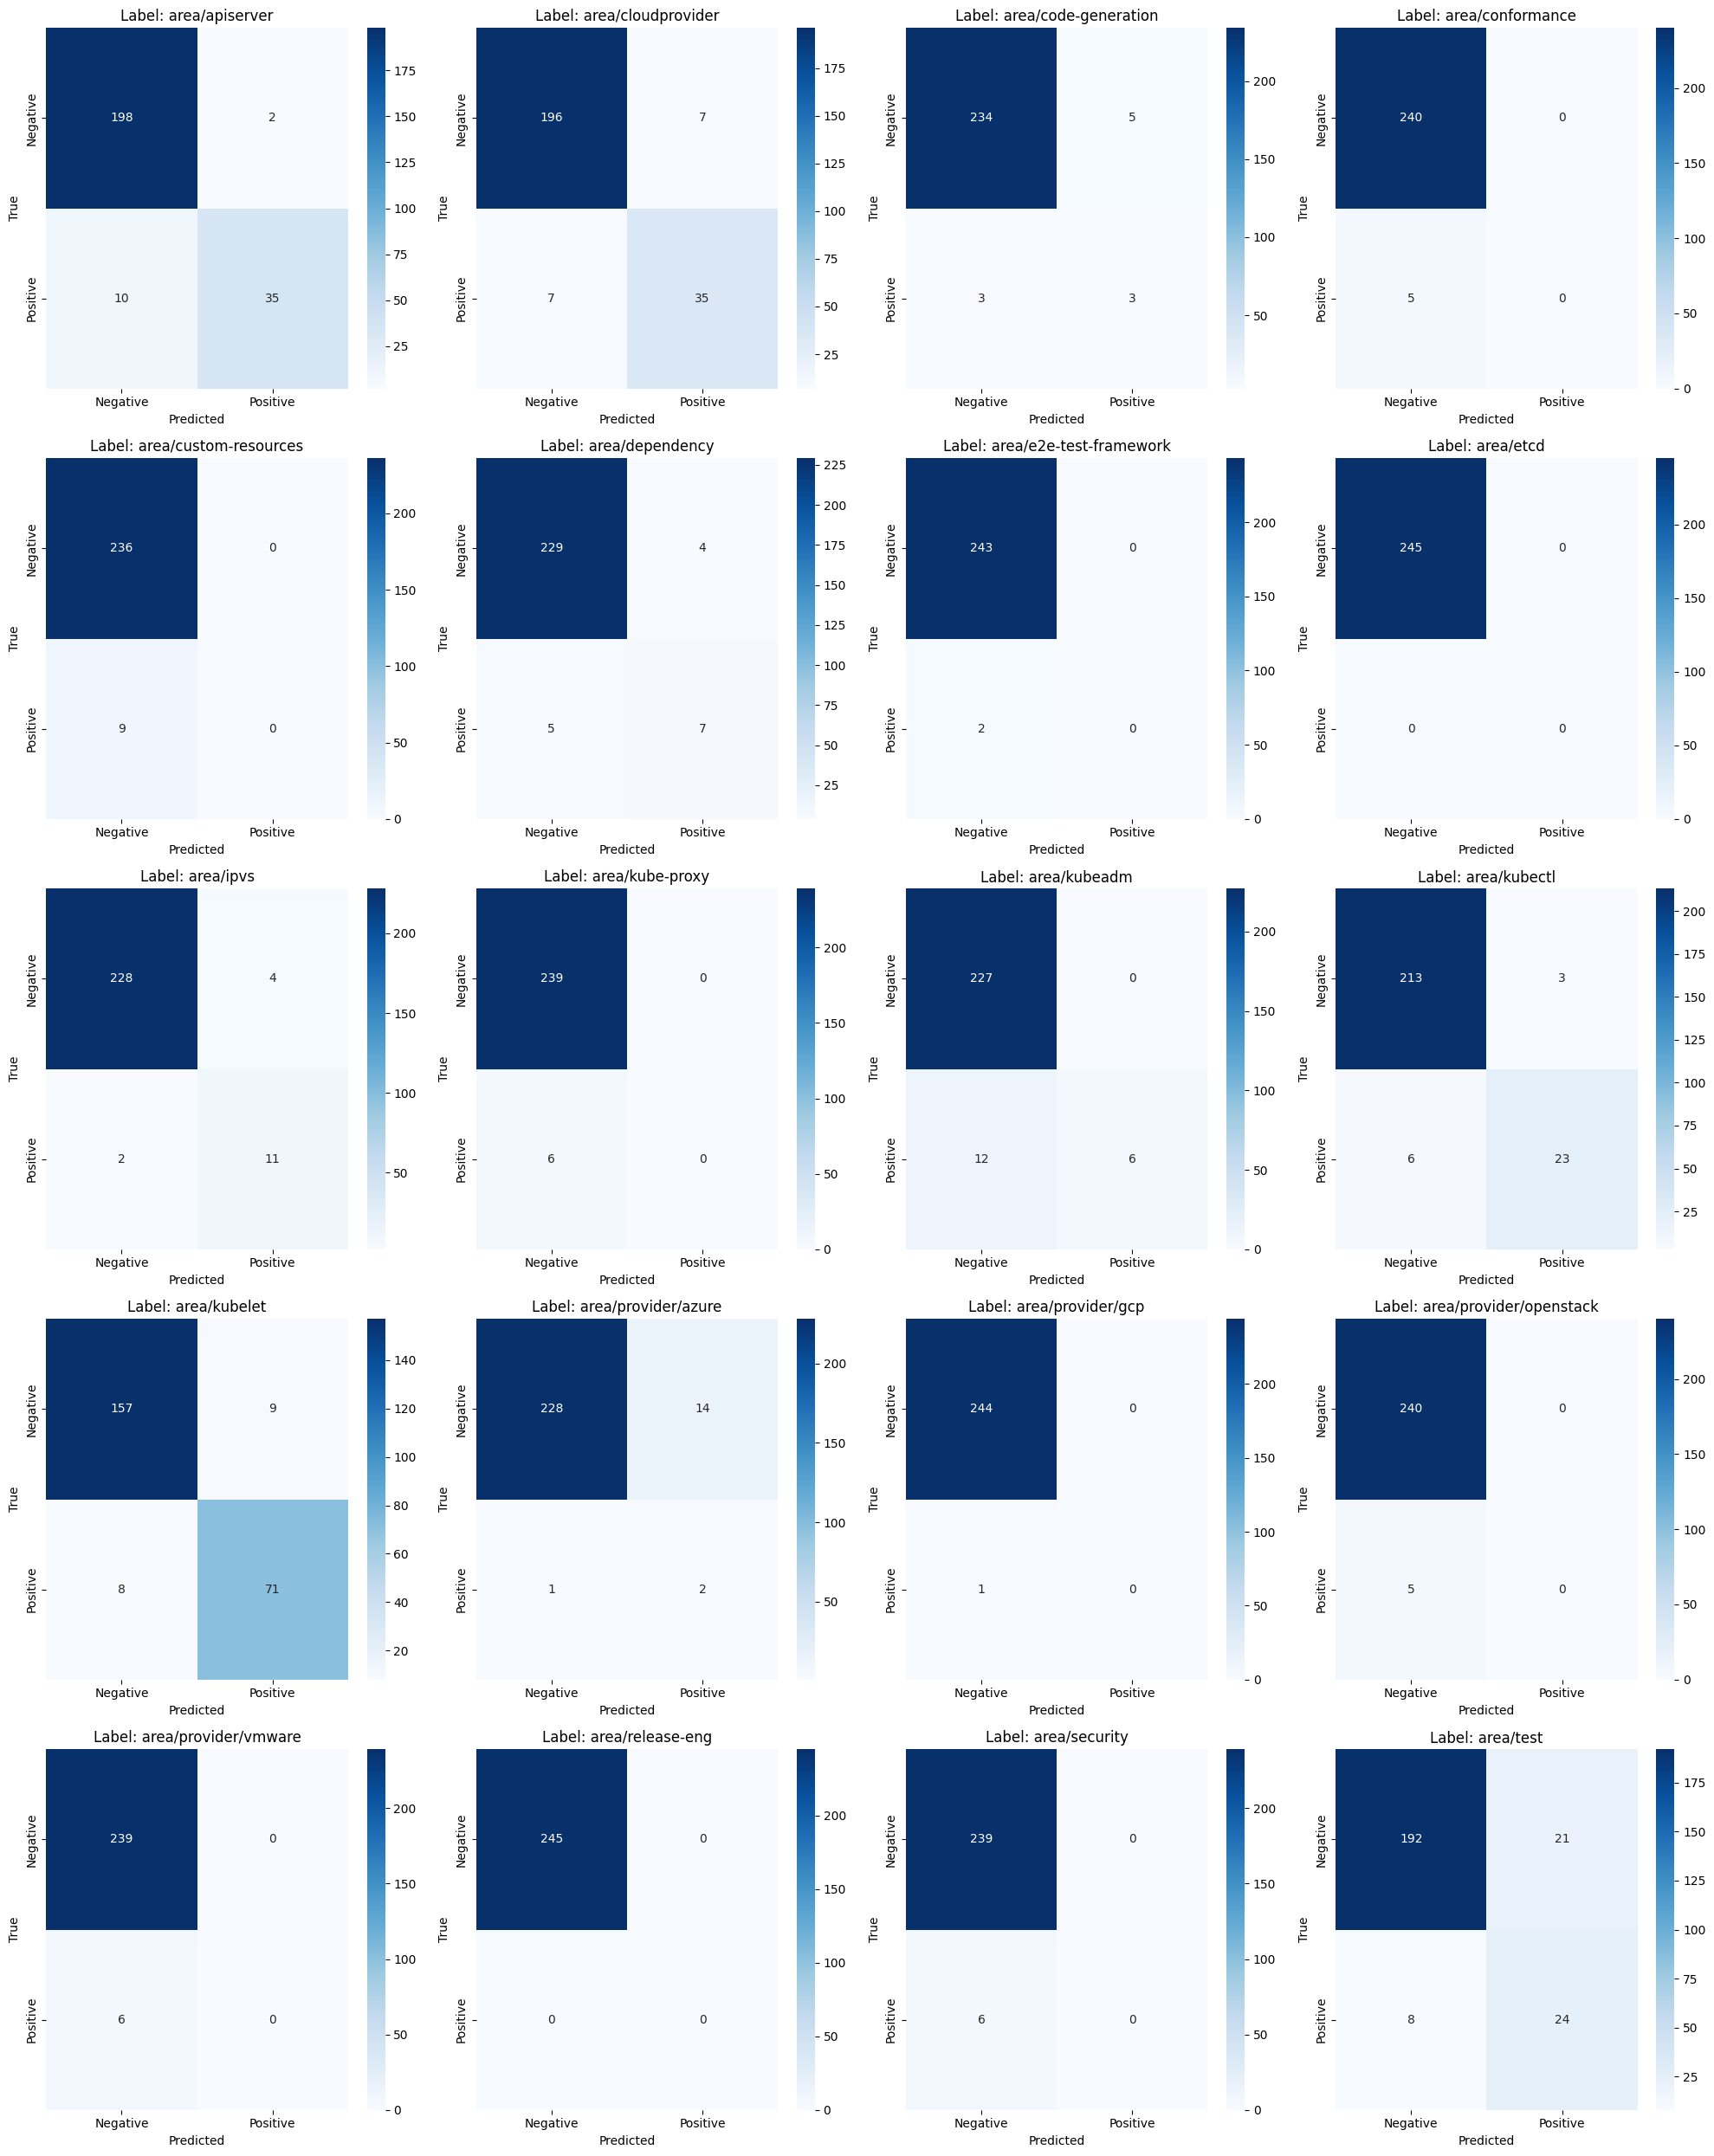

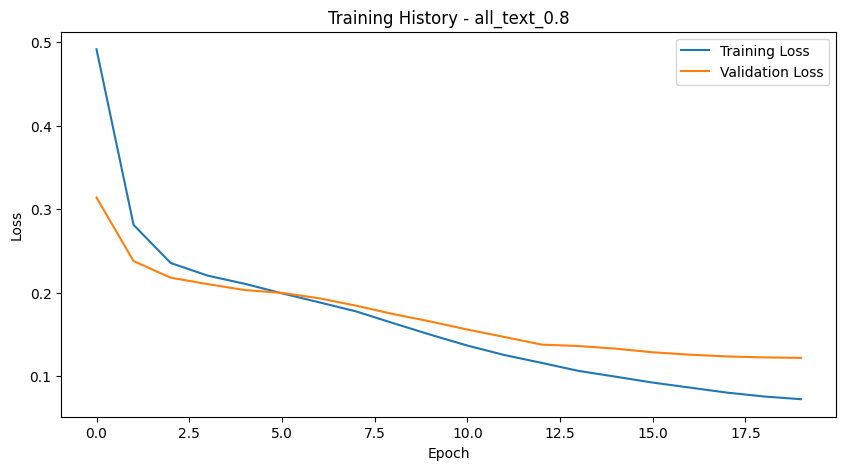

In [15]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.8',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

## Threshold 0.9

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, count:

Training: 100%|██████████| 31/31 [00:30<00:00,  1.02it/s]


Train Loss: 0.4915, Train Accuracy (Exact Match): 0.0123
Val Loss: 0.3141
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 2/20


Training: 100%|██████████| 31/31 [00:30<00:00,  1.02it/s]


Train Loss: 0.2812, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2379
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.06it/s]


Train Loss: 0.2356, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2180
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.2206, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2104
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.2111, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2036
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.9349
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.2004, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2001
Val Accuracy (Exact Match): 0.0082
Val Accuracy (Hamming): 0.9363
Val Accuracy (Jaccard): 0.0246
Val Precision: 0.0357, Val Recall: 0.0269, Val F1: 0.0299
Saved new best model to ./results/run_20250310_135700_all_text_0.9/best_model_all_text_0.9.pt

Epoch 7/20


Training: 100%|██████████| 31/31 [00:30<00:00,  1.02it/s]


Train Loss: 0.1897, Train Accuracy (Exact Match): 0.0164
Val Loss: 0.1937
Val Accuracy (Exact Match): 0.0204
Val Accuracy (Hamming): 0.9382
Val Accuracy (Jaccard): 0.0376
Val Precision: 0.0429, Val Recall: 0.0427, Val F1: 0.0417
Saved new best model to ./results/run_20250310_135700_all_text_0.9/best_model_all_text_0.9.pt

Epoch 8/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.1790, Train Accuracy (Exact Match): 0.1003
Val Loss: 0.1851
Val Accuracy (Exact Match): 0.2776
Val Accuracy (Hamming): 0.9498
Val Accuracy (Jaccard): 0.3073
Val Precision: 0.3395, Val Recall: 0.3096, Val F1: 0.3177
Saved new best model to ./results/run_20250310_135700_all_text_0.9/best_model_all_text_0.9.pt

Epoch 9/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.1655, Train Accuracy (Exact Match): 0.2272
Val Loss: 0.1749
Val Accuracy (Exact Match): 0.3347
Val Accuracy (Hamming): 0.9565
Val Accuracy (Jaccard): 0.4077
Val Precision: 0.4747, Val Recall: 0.4187, Val F1: 0.4315
Saved new best model to ./results/run_20250310_135700_all_text_0.9/best_model_all_text_0.9.pt

Epoch 10/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.1520, Train Accuracy (Exact Match): 0.3685
Val Loss: 0.1653
Val Accuracy (Exact Match): 0.3551
Val Accuracy (Hamming): 0.9567
Val Accuracy (Jaccard): 0.4501
Val Precision: 0.5159, Val Recall: 0.4829, Val F1: 0.4813
Saved new best model to ./results/run_20250310_135700_all_text_0.9/best_model_all_text_0.9.pt

Epoch 11/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.1383, Train Accuracy (Exact Match): 0.4524
Val Loss: 0.1569
Val Accuracy (Exact Match): 0.3551
Val Accuracy (Hamming): 0.9565
Val Accuracy (Jaccard): 0.4531
Val Precision: 0.5230, Val Recall: 0.4835, Val F1: 0.4849
Saved new best model to ./results/run_20250310_135700_all_text_0.9/best_model_all_text_0.9.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.1274, Train Accuracy (Exact Match): 0.4882
Val Loss: 0.1469
Val Accuracy (Exact Match): 0.3796
Val Accuracy (Hamming): 0.9578
Val Accuracy (Jaccard): 0.4782
Val Precision: 0.5503, Val Recall: 0.5116, Val F1: 0.5118
Saved new best model to ./results/run_20250310_135700_all_text_0.9/best_model_all_text_0.9.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.1177, Train Accuracy (Exact Match): 0.5650
Val Loss: 0.1392
Val Accuracy (Exact Match): 0.4122
Val Accuracy (Hamming): 0.9598
Val Accuracy (Jaccard): 0.5048
Val Precision: 0.5755, Val Recall: 0.5313, Val F1: 0.5360
Saved new best model to ./results/run_20250310_135700_all_text_0.9/best_model_all_text_0.9.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.1080, Train Accuracy (Exact Match): 0.5834
Val Loss: 0.1348
Val Accuracy (Exact Match): 0.4408
Val Accuracy (Hamming): 0.9606
Val Accuracy (Jaccard): 0.5399
Val Precision: 0.6112, Val Recall: 0.5722, Val F1: 0.5738
Saved new best model to ./results/run_20250310_135700_all_text_0.9/best_model_all_text_0.9.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.1004, Train Accuracy (Exact Match): 0.6315
Val Loss: 0.1325
Val Accuracy (Exact Match): 0.4776
Val Accuracy (Hamming): 0.9624
Val Accuracy (Jaccard): 0.5690
Val Precision: 0.6429, Val Recall: 0.5951, Val F1: 0.6010
Saved new best model to ./results/run_20250310_135700_all_text_0.9/best_model_all_text_0.9.pt

Epoch 16/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.0942, Train Accuracy (Exact Match): 0.6530
Val Loss: 0.1280
Val Accuracy (Exact Match): 0.5184
Val Accuracy (Hamming): 0.9645
Val Accuracy (Jaccard): 0.6152
Val Precision: 0.6898, Val Recall: 0.6448, Val F1: 0.6484
Saved new best model to ./results/run_20250310_135700_all_text_0.9/best_model_all_text_0.9.pt

Epoch 17/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.0883, Train Accuracy (Exact Match): 0.6643
Val Loss: 0.1257
Val Accuracy (Exact Match): 0.5224
Val Accuracy (Hamming): 0.9653
Val Accuracy (Jaccard): 0.6222
Val Precision: 0.6959, Val Recall: 0.6537, Val F1: 0.6562
Saved new best model to ./results/run_20250310_135700_all_text_0.9/best_model_all_text_0.9.pt

Epoch 18/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.0822, Train Accuracy (Exact Match): 0.6929
Val Loss: 0.1234
Val Accuracy (Exact Match): 0.5469
Val Accuracy (Hamming): 0.9657
Val Accuracy (Jaccard): 0.6520
Val Precision: 0.7220, Val Recall: 0.6916, Val F1: 0.6877
Saved new best model to ./results/run_20250310_135700_all_text_0.9/best_model_all_text_0.9.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.0776, Train Accuracy (Exact Match): 0.7073
Val Loss: 0.1214
Val Accuracy (Exact Match): 0.5388
Val Accuracy (Hamming): 0.9653
Val Accuracy (Jaccard): 0.6507
Val Precision: 0.7235, Val Recall: 0.6966, Val F1: 0.6894
Saved new best model to ./results/run_20250310_135700_all_text_0.9/best_model_all_text_0.9.pt

Epoch 20/20


Training: 100%|██████████| 31/31 [00:30<00:00,  1.03it/s]


Train Loss: 0.0742, Train Accuracy (Exact Match): 0.7165
Val Loss: 0.1213
Val Accuracy (Exact Match): 0.5551
Val Accuracy (Hamming): 0.9653
Val Accuracy (Jaccard): 0.6703
Val Precision: 0.7325, Val Recall: 0.7248, Val F1: 0.7093
Saved new best model to ./results/run_20250310_135700_all_text_0.9/best_model_all_text_0.9.pt

Loading best model for final evaluation...


<ipython-input-10-1ee0104d141d>:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.5551
Hamming Accuracy: 0.9653
Jaccard Similarity: 0.6703
Precision: 0.7325
Recall: 0.7248
F1 Score: 0.7093

Training completed! Results saved to ./results/run_20250310_135700_all_text_0.9


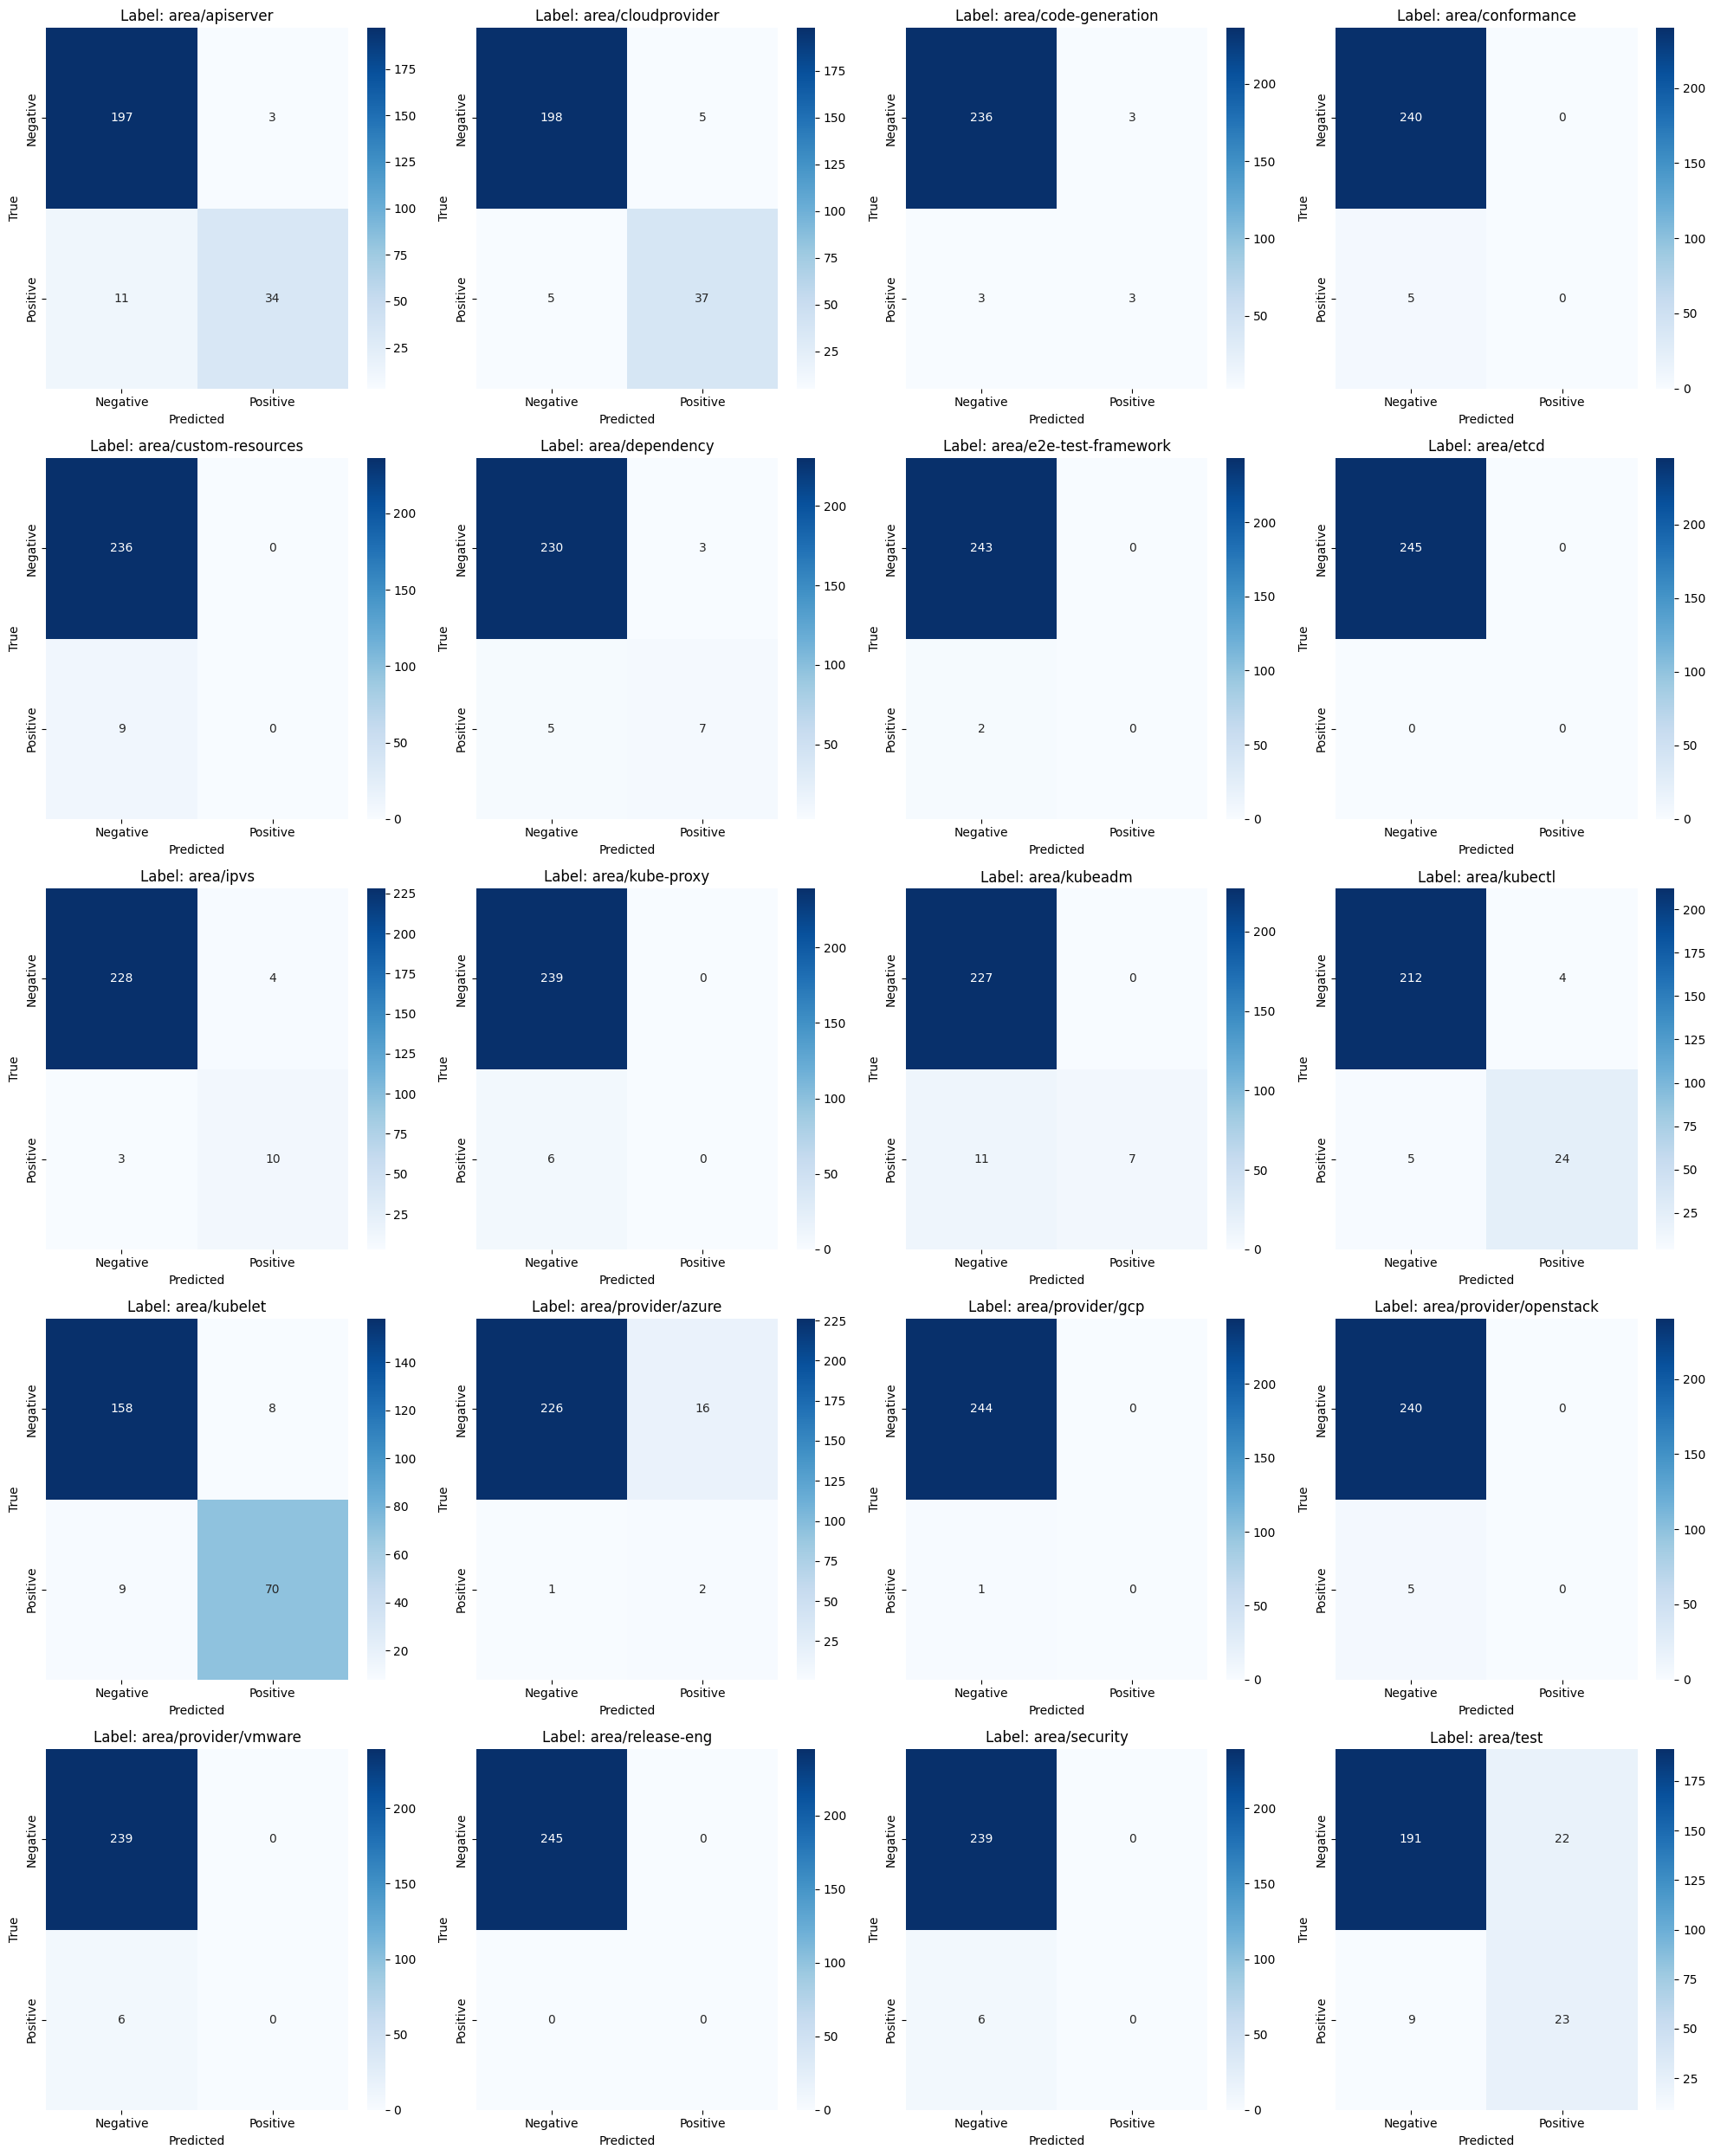

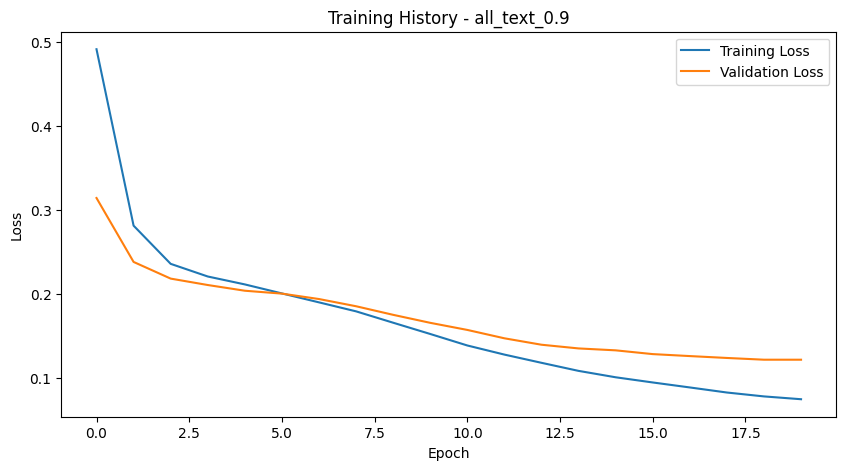

In [16]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.9',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)